# WiDS Datathon 2025: Predicting ADHD and Sex from fMRI Data

This notebook provides a step-by-step guide to solving the WiDS Datathon 2025 challenge. The goal is to predict both an individual's sex and their ADHD diagnosis using functional brain imaging data, socio-demographic information, and other metadata.

V3.3 - Last updated on 11 April 2025 to handle both new and old datasets. This notebook was run on the new data.

This notebook covers the end-to-end process, from data import, exploratory data analysis, data preprocessing to model selection (CatBoost and LGBM) and evaluation.

---

## Table of Contents
1. [Introduction](#introduction)
2. [Data Loading](#data-loading)
3. [Exploratory Data Analysis (EDA)](#eda)
4. [Data Preprocessing](#data-preprocessing)
5. [Model Training](#model-training)
6. [Model Evaluation](#model-evaluation)
7. [Submission Generation](#submission-generation)
8. [Conclusion](#conclusion)

---

## 1. Introduction <a name="introduction"></a>

The WiDS Datathon 2025 focuses on uncovering patterns in ADHD diagnosis and sex differences using fMRI data. The dataset includes:
- Functional MRI connectome matrices
- Socio-demographic information
- Emotional and parenting questionnaire data

Our task is to build a multi-output model to predict:
1. ADHD diagnosis (`ADHD_Outcome`: 1 = yes, 0 = no)
2. Sex (`Sex_F`: 1 = female, 0 = male)

---

## 2. Data Loading <a name="data-loading"></a>

We start by loading the training and test datasets.

Import libraries:

In [2]:
import numpy as np
import pandas as pd
import warnings
import time

Ignore filter warning messages

In [3]:
warnings.filterwarnings('ignore')

Start runtime measurement:

In [4]:
start_time = time.time()

#### Run setting

Run setting is either 'local' or 'kaggle', this determines the input and output folders as follows.

In case of 'kaggle':
- input_folder  = /kaggle/input/widsdatathon2025
- output_folder = /kaggle/working   

    These folders should be unchanged as specified by Kaggle.

In case of 'local':
- input_folder  = /data               (data assumed to be saved in the same subfolders of this folder as on Kaggle, please amend as necessary)
- output_folder = /output             (please amend as necessary)

    These folders are relative to your local working directory. You can check your local working directory by running %pwd in a code cell.


The user can specify the setting below:

In [5]:
run_setting = 'local'

The input and output folders are specified according to the run_setting above:

In [6]:
if run_setting == 'kaggle':
    input_folder  = '/kaggle/input/widsdatathon2025'
    output_folder = '/kaggle/working'

else:
    input_folder  = 'data'
    output_folder = 'output'

# Old or new version of the data? Old or new version of the data? Set suffices if NEW:

In [7]:
old_or_new = 'NEW'

if old_or_new == 'OLD':
    filename_suffix_cat = ''
    filename_suffix_quant = ''
    filename_suffix_connectome = ''

else:
    filename_suffix_cat       = '_new'
    filename_suffix_quant     = '_new'
    filename_suffix_connectome = '_new_36P_Pearson'

Import the whole dataset into a single dataframe (for both training and test data):

In [8]:
# %%
def get_feats(data_input_folder, mode):
    """
    Load data for the specified mode (TRAIN or TEST).
    """
    
    # Load datasets based on the mode:
    if mode == 'TRAIN':
        # Load categorical data:
        cat_features         = pd.read_excel(f"{data_input_folder}/{mode}_{old_or_new}/{mode}_CATEGORICAL_METADATA{filename_suffix_cat}.xlsx")
        # Load quantitative data:
        quant_features       = pd.read_excel(f"{data_input_folder}/{mode}_{old_or_new}/{mode}_QUANTITATIVE_METADATA{filename_suffix_quant}.xlsx")
        # Load connectome matrices:
        connectome_features  = pd.read_csv(f"{data_input_folder}/{mode}_{old_or_new}/{mode}_FUNCTIONAL_CONNECTOME_MATRICES{filename_suffix_connectome}.csv")
        # Load solutions:
        solution = pd.read_excel(f"{data_input_folder}/TRAIN_{old_or_new}/TRAINING_SOLUTIONS.xlsx")
    else:
        # Load categorical data:
        cat_features         = pd.read_excel(f"{data_input_folder}/{mode}/{mode}_CATEGORICAL.xlsx")
        # Load quantitative data:
        quant_features       = pd.read_excel(f"{data_input_folder}/{mode}/{mode}_QUANTITATIVE_METADATA.xlsx")
        # Load connectome matrices:
        connectome_features  = pd.read_csv(f"{data_input_folder}/{mode}/{mode}_FUNCTIONAL_CONNECTOME_MATRICES.csv")
        # Solution not available for test data
        solution = None


    # Merge datasets into one:
    features = pd.merge(quant_features, cat_features, on='participant_id', how='left')
    features = pd.merge(features, connectome_features, on='participant_id', how='left')

    if mode == 'TRAIN':
        # Merge with solutions
        features = pd.merge(features, solution, on='participant_id', how='left')
    
    return features, cat_features, quant_features, connectome_features, solution

# Load training and test data - aggragete and by dataset type:
print("Loading data...")
train, train_cat, train_quant, train_connectome, train_solutions = get_feats(data_input_folder = input_folder, mode='TRAIN')
test, test_cat, test_quant, test_connectome, _                   = get_feats(data_input_folder = input_folder, mode='TEST')

# Display the first few rows of the training data
train.head()

Loading data...


,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,...,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn,ADHD_Outcome,Sex_F
0,00aIpNTbG5uh,100.00,13.0,3.0,15.0,44.0,14.0,20.0,27.0,3.0,...,-0.280312,0.037560,0.423037,0.242453,0.336213,0.402338,0.327915,0.539032,1,0
1,00fV0OyyoLfw,92.27,14.0,3.0,12.0,35.0,25.0,28.0,30.0,5.0,...,-0.332783,-0.332711,0.556939,0.475578,0.429196,0.457970,0.312571,0.595978,1,0
2,04X1eiS79T4B,86.67,14.0,3.0,21.0,37.0,18.0,26.0,28.0,3.0,...,-0.002132,-0.175586,0.679183,0.290292,0.486680,0.255208,0.575017,0.605182,0,1
3,05ocQutkURd6,93.34,14.0,3.0,11.0,42.0,15.0,20.0,28.0,0.0,...,-0.199576,-0.216457,0.519074,0.298586,0.415466,0.511607,0.361204,0.446613,0,1
4,06YUNBA9ZRLq,0.00,14.0,8.0,12.0,35.0,22.0,12.0,24.0,6.0,...,-0.141012,-0.002865,0.515169,0.336139,0.316430,0.442230,0.177079,0.378278,1,0


Check the size of the training dataset:

In [9]:
train.shape

(1213, 19930)

Check the size of the test dataset:

In [10]:
test.shape

(304, 19928)

## 3. Exploratory Data Analysis <a name="eda"></a>

### Import libraries:

Import additional libraries for plotting:

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

### Target variables (used for splits)

Inspect target variables (or solutions):

In [12]:
train_solutions.head()

,participant_id,ADHD_Outcome,Sex_F
0,UmrK0vMLopoR,1,1
1,CPaeQkhcjg7d,1,0
2,Nb4EetVPm3gs,1,0
3,p4vPhVu91o4b,1,1
4,M09PXs7arQ5E,1,1


The train_solutions dataset contains labels for `ADHD` and `gender`. Let's examine the class distribution:

In [13]:
train_solutions['ADHD_Outcome'].value_counts()

ADHD_Outcome
1    831
0    382
Name: count, dtype: int64

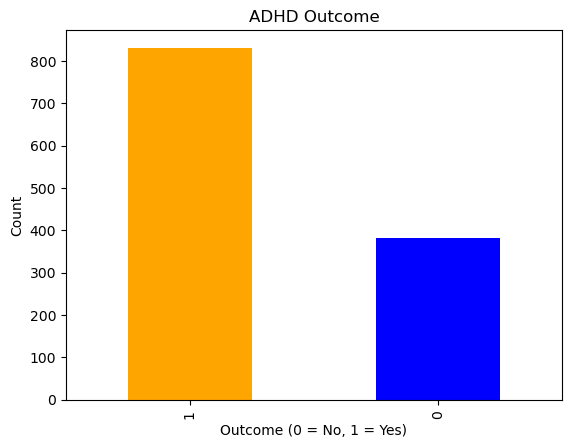

In [14]:
train_solutions['ADHD_Outcome'].value_counts().plot(kind='bar', color = ['orange', 'blue'])
plt.title('ADHD Outcome')
plt.xlabel('Outcome (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

In [15]:
train_solutions['Sex_F'].value_counts()

Sex_F
0    797
1    416
Name: count, dtype: int64

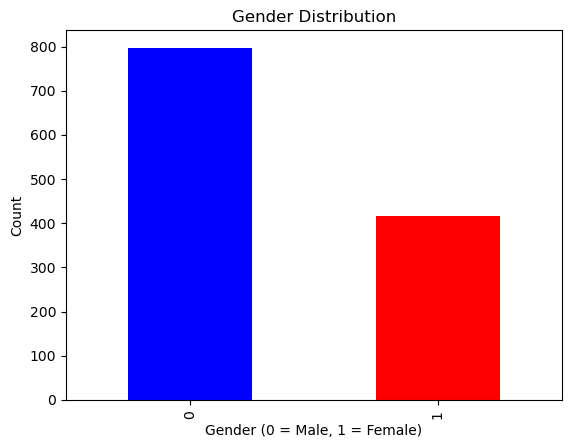

In [16]:
train_solutions['Sex_F'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.title('Gender Distribution')
plt.xlabel('Gender (0 = Male, 1 = Female)')
plt.ylabel('Count')
plt.show()

We see that the training dataset is quite imbalanced - majority of patients (831 out of 1213 or 67%) are diagnosed with ADHD and the majority of patients (797 out of 1213 or 66%) are male. This may need to be addressed later e.g. by oversampling of the minority classes. 

### Categorical variables

Inspect categorical variables - training data:

In [17]:
train_cat.head()

,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
0,00aIpNTbG5uh,2019,4,1.0,0.0,3.0,21.0,45.0,NaN,NaN
1,00fV0OyyoLfw,2017,1,0.0,9.0,2.0,21.0,0.0,21.0,45.0
2,04X1eiS79T4B,2017,1,1.0,2.0,2.0,9.0,0.0,NaN,NaN
3,05ocQutkURd6,2018,1,3.0,8.0,2.0,18.0,10.0,18.0,0.0
4,06YUNBA9ZRLq,2018,1,0.0,1.0,2.0,12.0,0.0,NaN,NaN


View number of rows and columns (=shape) of the original dataframe:

In [18]:
train_cat.shape

(1213, 10)

Check columns names of categorical variables:

In [19]:
train_cat.columns

Index(['participant_id', 'Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site',
       'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
       'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu',
       'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
       'Barratt_Barratt_P2_Occ'],
      dtype='object')

Use `.info()` and `.describe()` to provide basic informatino and descriptive statistics about the categorical data:

In [20]:
train_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   participant_id                    1213 non-null   object 
 1   Basic_Demos_Enroll_Year           1213 non-null   int64  
 2   Basic_Demos_Study_Site            1213 non-null   int64  
 3   PreInt_Demos_Fam_Child_Ethnicity  1170 non-null   float64
 4   PreInt_Demos_Fam_Child_Race       1159 non-null   float64
 5   MRI_Track_Scan_Location           1210 non-null   float64
 6   Barratt_Barratt_P1_Edu            1198 non-null   float64
 7   Barratt_Barratt_P1_Occ            1182 non-null   float64
 8   Barratt_Barratt_P2_Edu            1015 non-null   float64
 9   Barratt_Barratt_P2_Occ            991 non-null    float64
dtypes: float64(7), int64(2), object(1)
memory usage: 94.9+ KB


We can see that the dataset is quite complete, but there are some missing values (items where non-null count < 1213, the number of participants):
- PreInt_Demos_Fam_Child_Ethnicity - 43 (= 1213 - 1170)
- PreInt_Demos_Fam_Child_Race - 54
- MRI_Track_Scan_Location - 3
- Barratt_Barratt_P1_Edu - 15 
- Barratt_Barratt_P1_Occ - 31
- Barratt_Barratt_P2_Edu - 198
- Barratt_Barratt_P2_Occ - 222

Apart from the last two features, the number of missing values is relatively small (<5%).



In [21]:
train_cat.describe()

,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
count,1213.000000,1213.000000,1170.000000,1159.000000,1210.000000,1198.000000,1182.000000,1015.000000,991.000000
mean,2017.652102,2.014839,0.435897,2.177739,2.294215,17.862270,25.545685,16.876847,30.257316
std,1.122522,1.135147,0.693174,3.204782,0.750660,3.505608,16.757043,3.929558,13.901144
min,2015.000000,1.000000,0.000000,0.000000,1.000000,3.000000,0.000000,3.000000,0.000000
25%,2017.000000,1.000000,0.000000,0.000000,2.000000,15.000000,5.000000,15.000000,20.000000
50%,2018.000000,1.000000,0.000000,1.000000,2.000000,18.000000,30.000000,18.000000,35.000000
75%,2019.000000,3.000000,1.000000,2.000000,3.000000,21.000000,40.000000,21.000000,40.000000
max,2020.000000,4.000000,3.000000,11.000000,4.000000,21.000000,45.000000,21.000000,45.000000


#### Count plots (all variables):

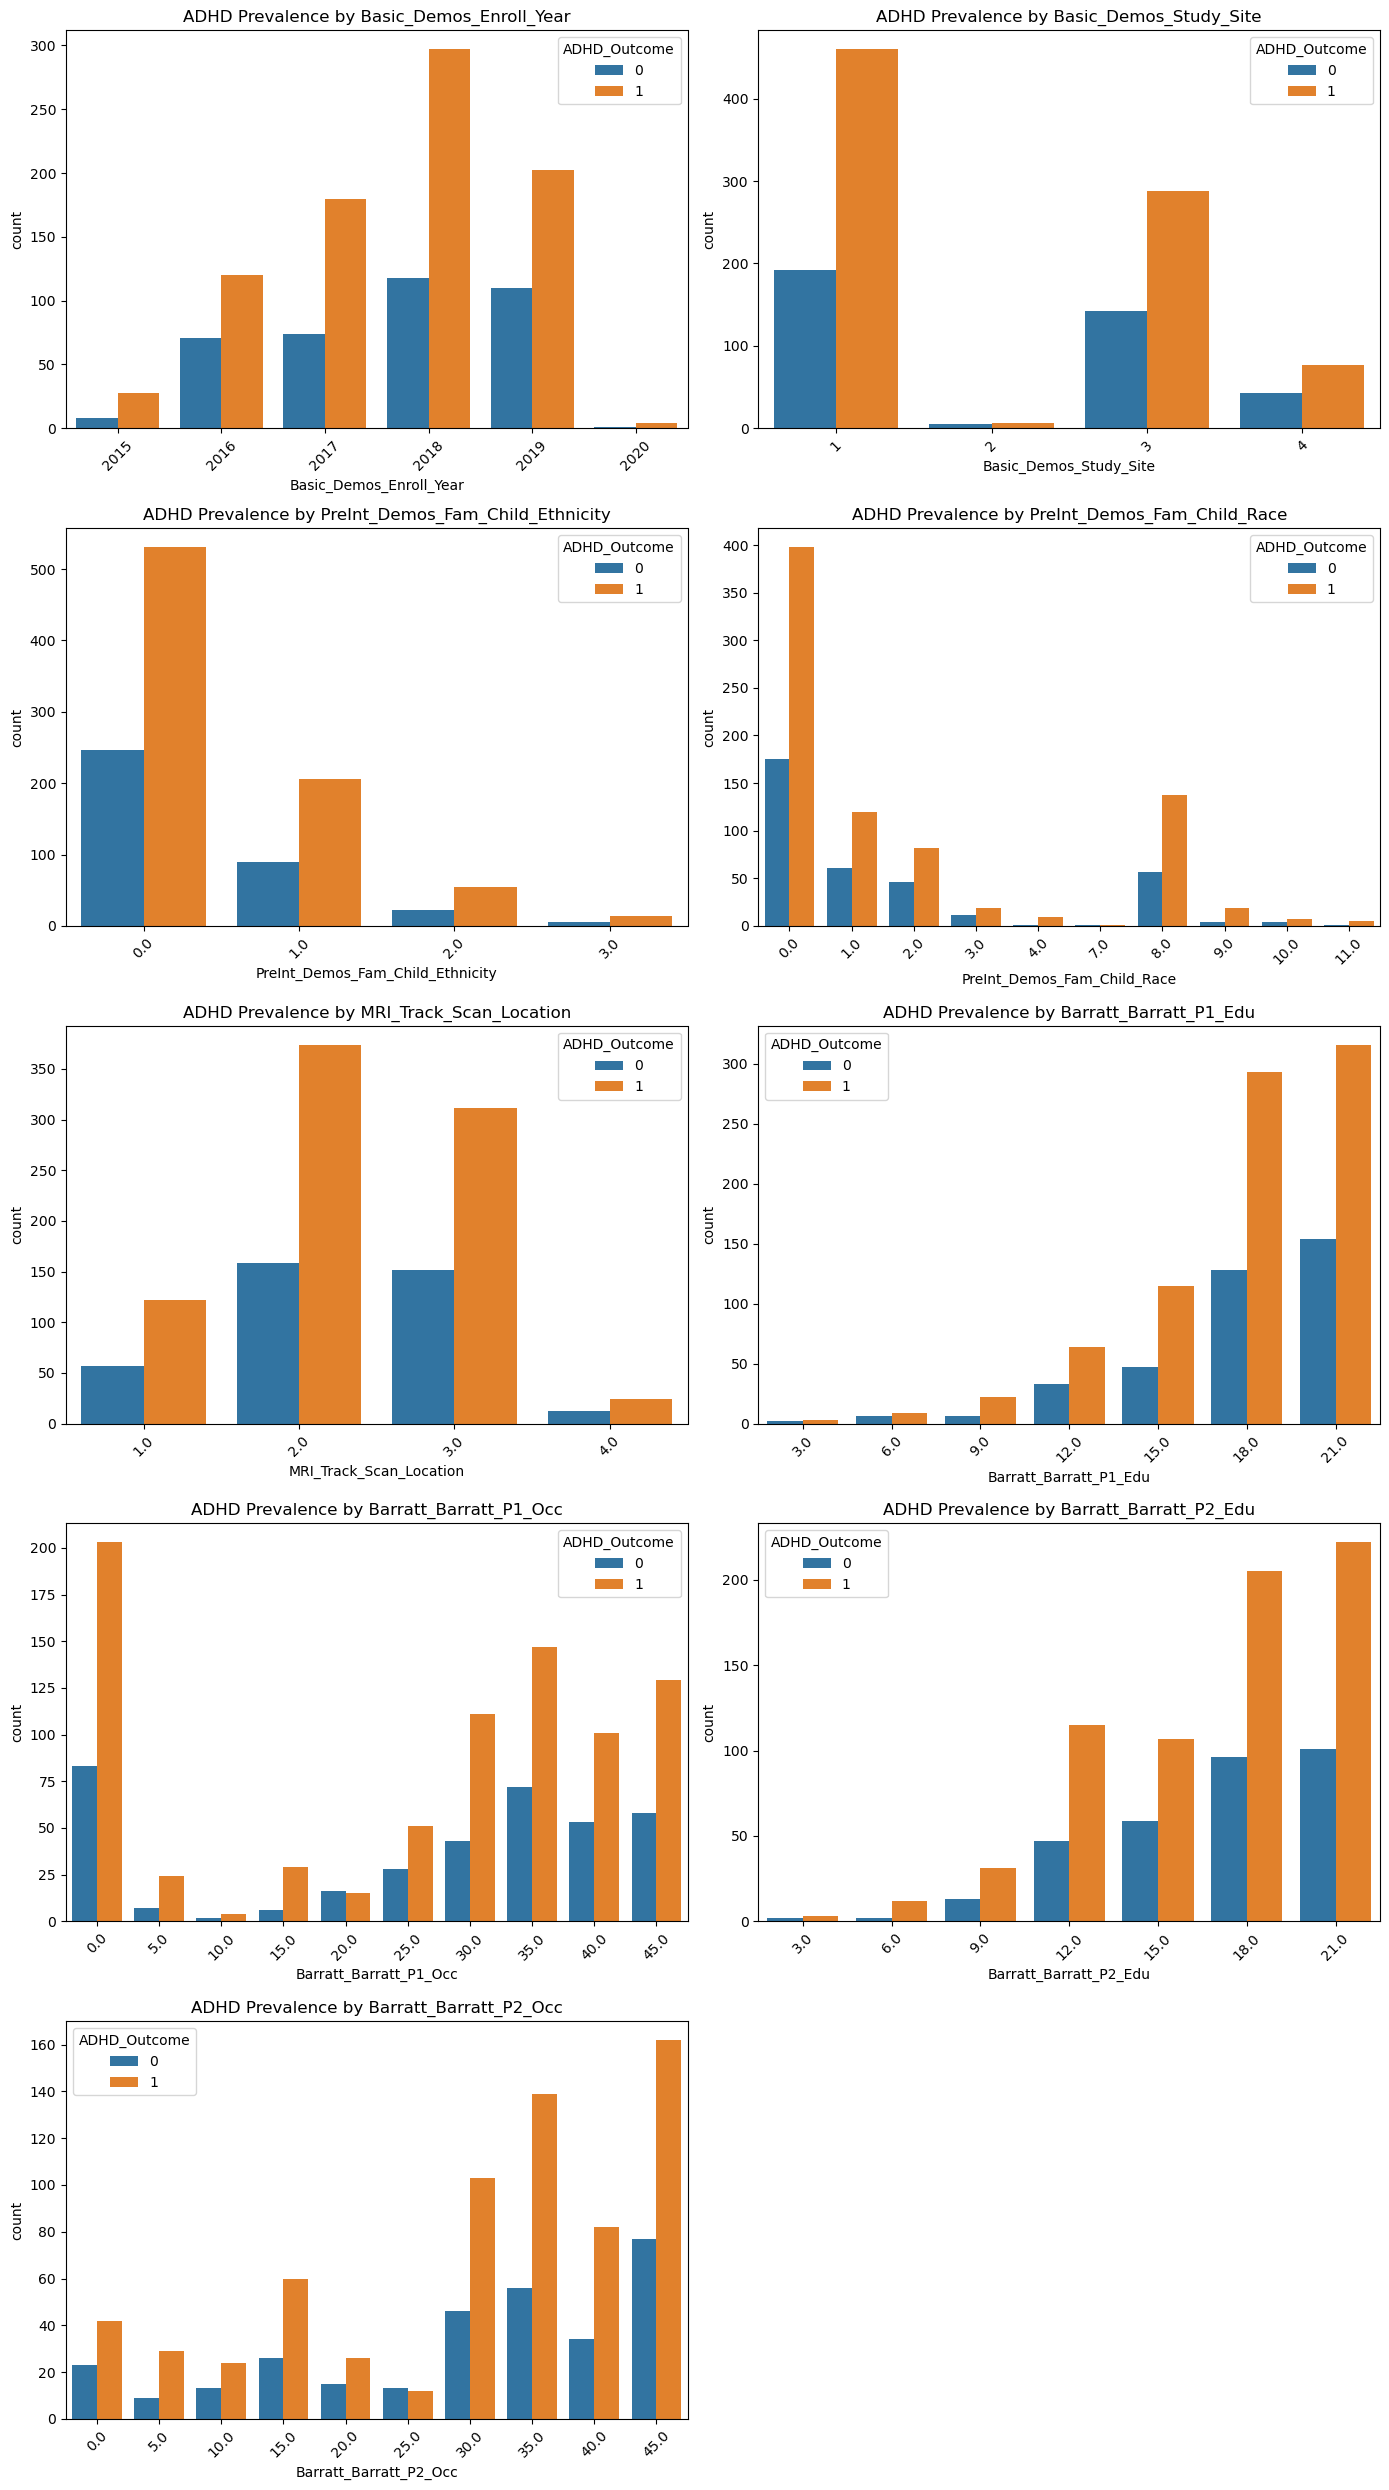

In [22]:
# Get list of categorical columns excluding 'participant_id'
cat_cols = [col for col in train_cat.columns if col != 'participant_id']

# Set up the figure dimensions; adjust as needed
n_cols = 2  # Number of columns per row
n_rows = (len(cat_cols) + 1) // n_cols  # Number of rows

plt.figure(figsize=(14, 5 * n_rows))

for idx, col in enumerate(cat_cols, 1):
    plt.subplot(n_rows, n_cols, idx)
    sns.countplot(data=train_cat, x=col, hue=train_solutions['ADHD_Outcome'])
    plt.title(f"ADHD Prevalence by {col}")
    plt.xticks(rotation=45)  # Rotate labels for better readability

plt.tight_layout()
plt.show()

#### Frequency plots (all variables):

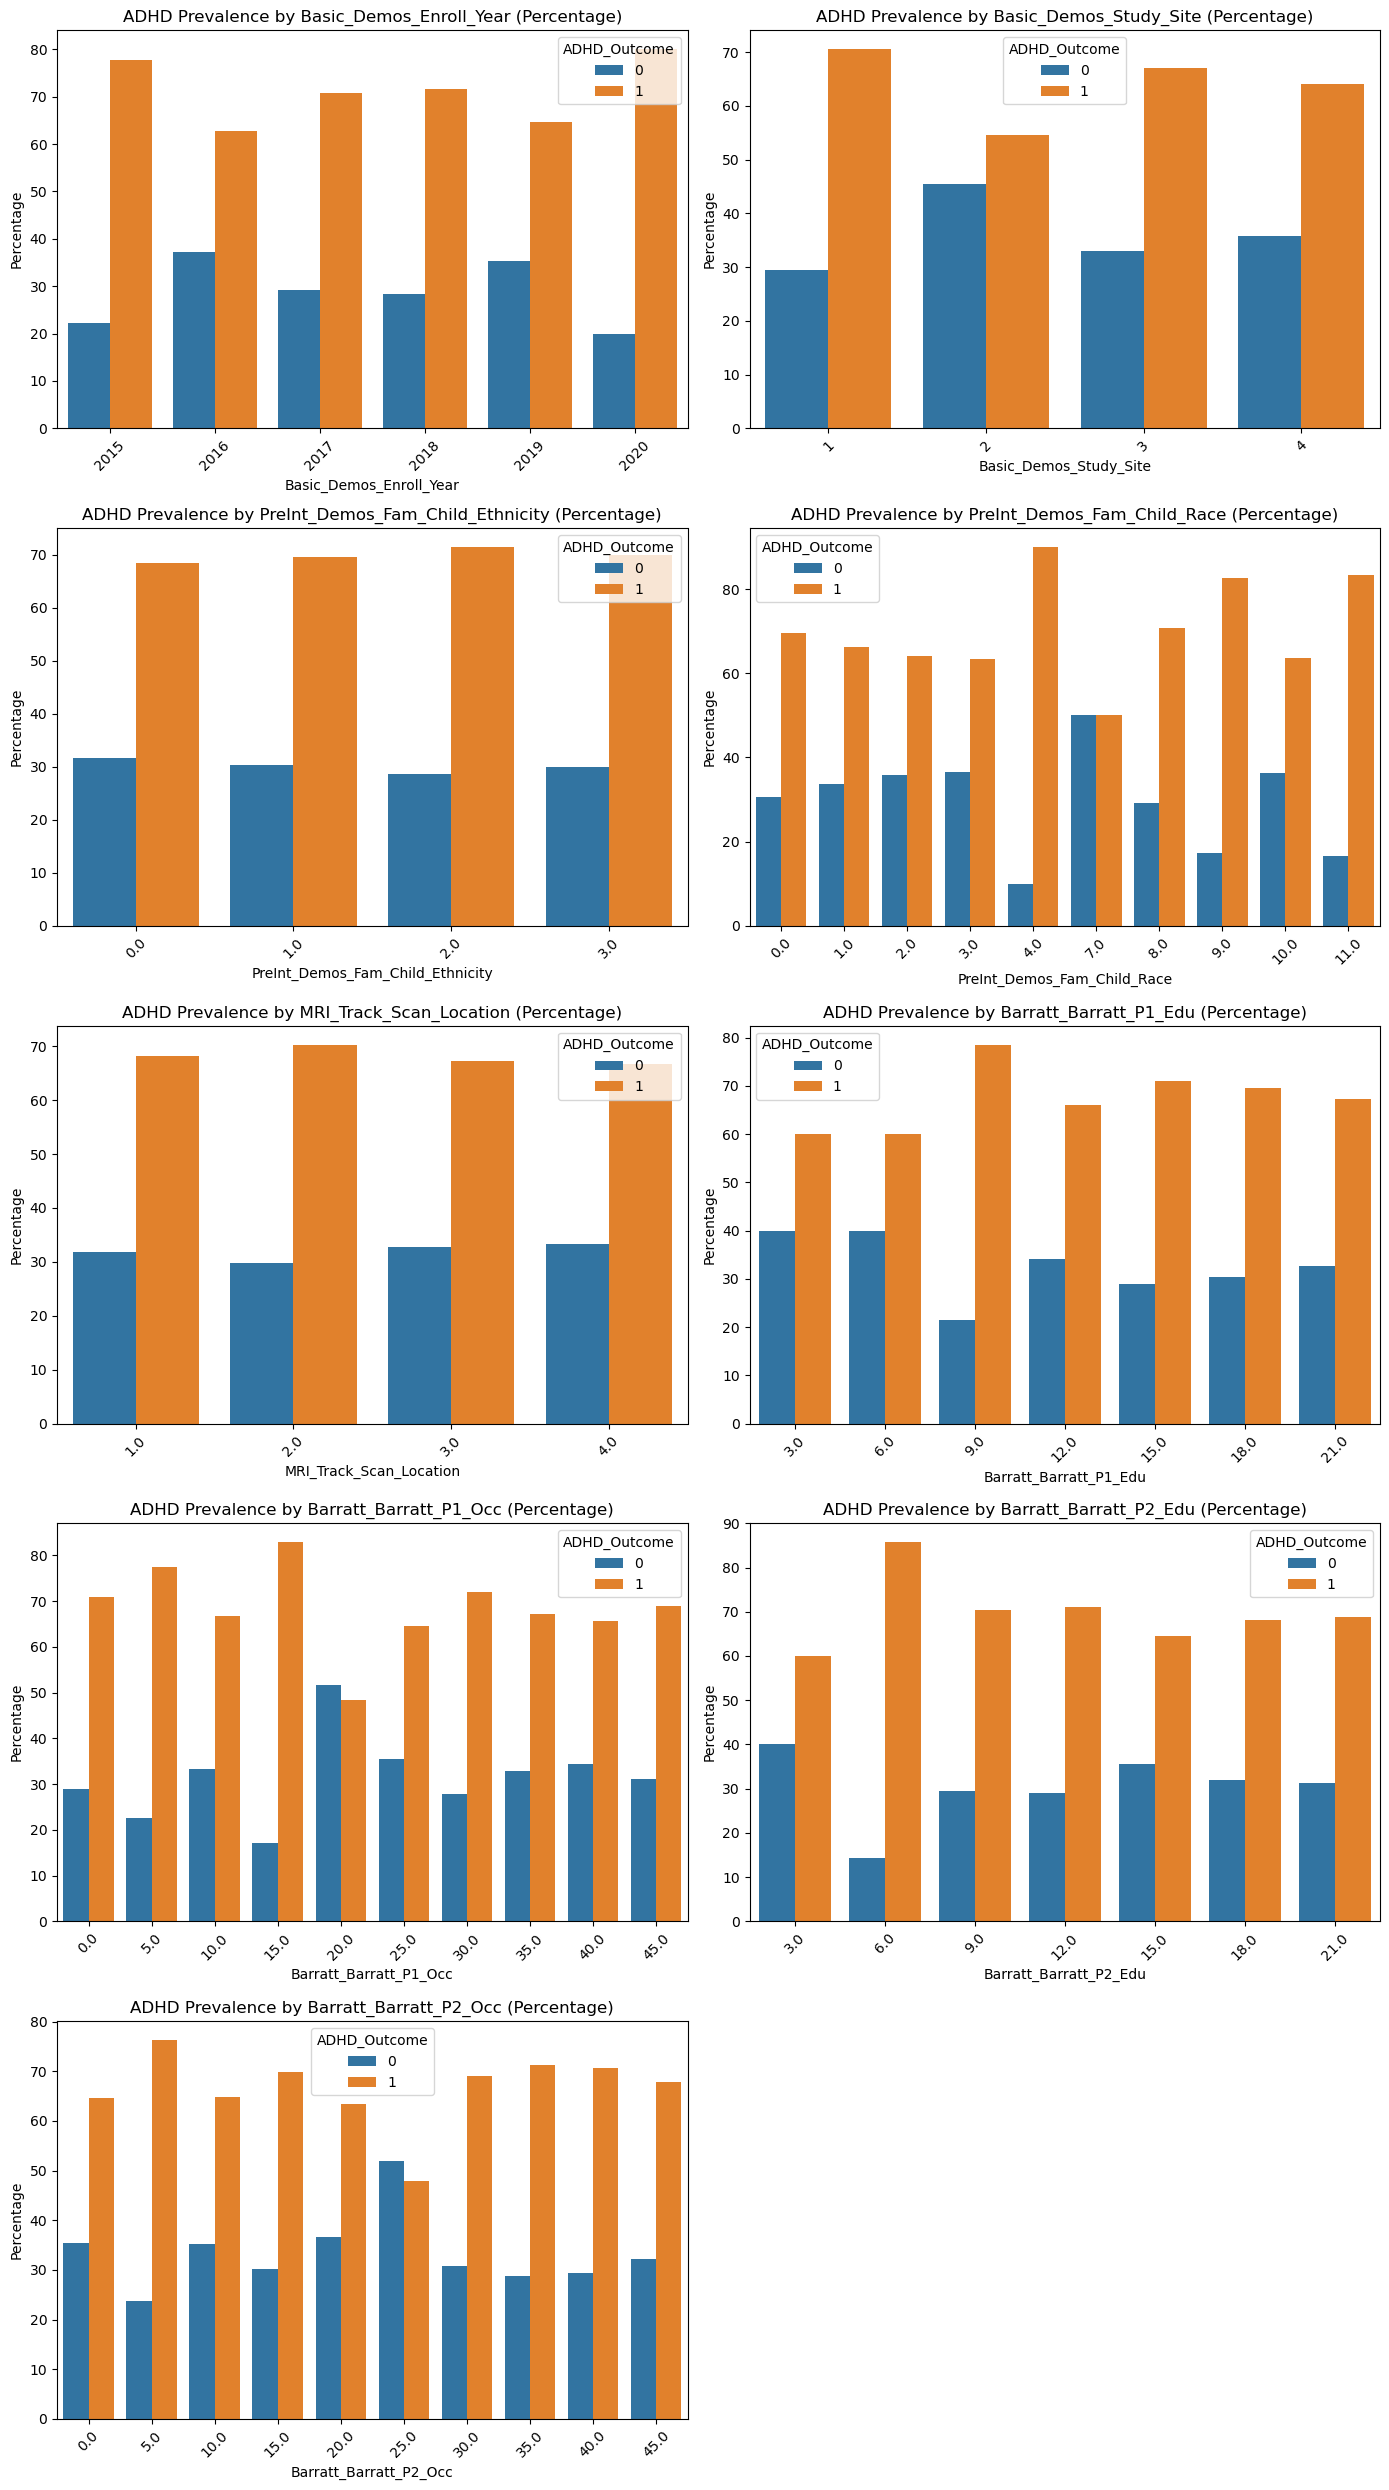

In [23]:
# Get list of categorical columns excluding 'participant_id'
cat_cols = [col for col in train_cat.columns if col != 'participant_id']

# Set up the figure dimensions; adjust as needed
n_cols = 2  # Number of columns per row
n_rows = (len(cat_cols) + 1) // n_cols  # Number of rows

plt.figure(figsize=(14, 5 * n_rows))

for idx, col in enumerate(cat_cols, 1):
    plt.subplot(n_rows, n_cols, idx)

    # Combine train_cat with ADHD outcome
    df_counts = train_cat[[col]].copy()  # Ensure we only take relevant column
    df_counts['ADHD_Outcome'] = train_solutions['ADHD_Outcome']

    # Compute counts
    df_percent = df_counts.groupby([col, 'ADHD_Outcome']).size().reset_index(name='count')

    # Compute percentages (normalize within each category of col)
    df_percent['percentage'] = df_percent.groupby(col)['count'].transform(lambda x: x / x.sum() * 100)

    # Create bar plot with percentages
    sns.barplot(data=df_percent, x=col, y="percentage", hue="ADHD_Outcome")

    plt.title(f"ADHD Prevalence by {col} (Percentage)")
    plt.ylabel("Percentage")
    plt.xticks(rotation=45)  # Rotate labels for better readability

plt.tight_layout()
plt.show()

#### Compare distributions of feature values in training vs test dataset

Verify that the columns are the same between the training and test dataset:

In [24]:
train_cat.columns

Index(['participant_id', 'Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site',
       'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
       'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu',
       'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
       'Barratt_Barratt_P2_Occ'],
      dtype='object')

In [25]:
test_cat.columns

Index(['participant_id', 'Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site',
       'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
       'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu',
       'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
       'Barratt_Barratt_P2_Occ'],
      dtype='object')

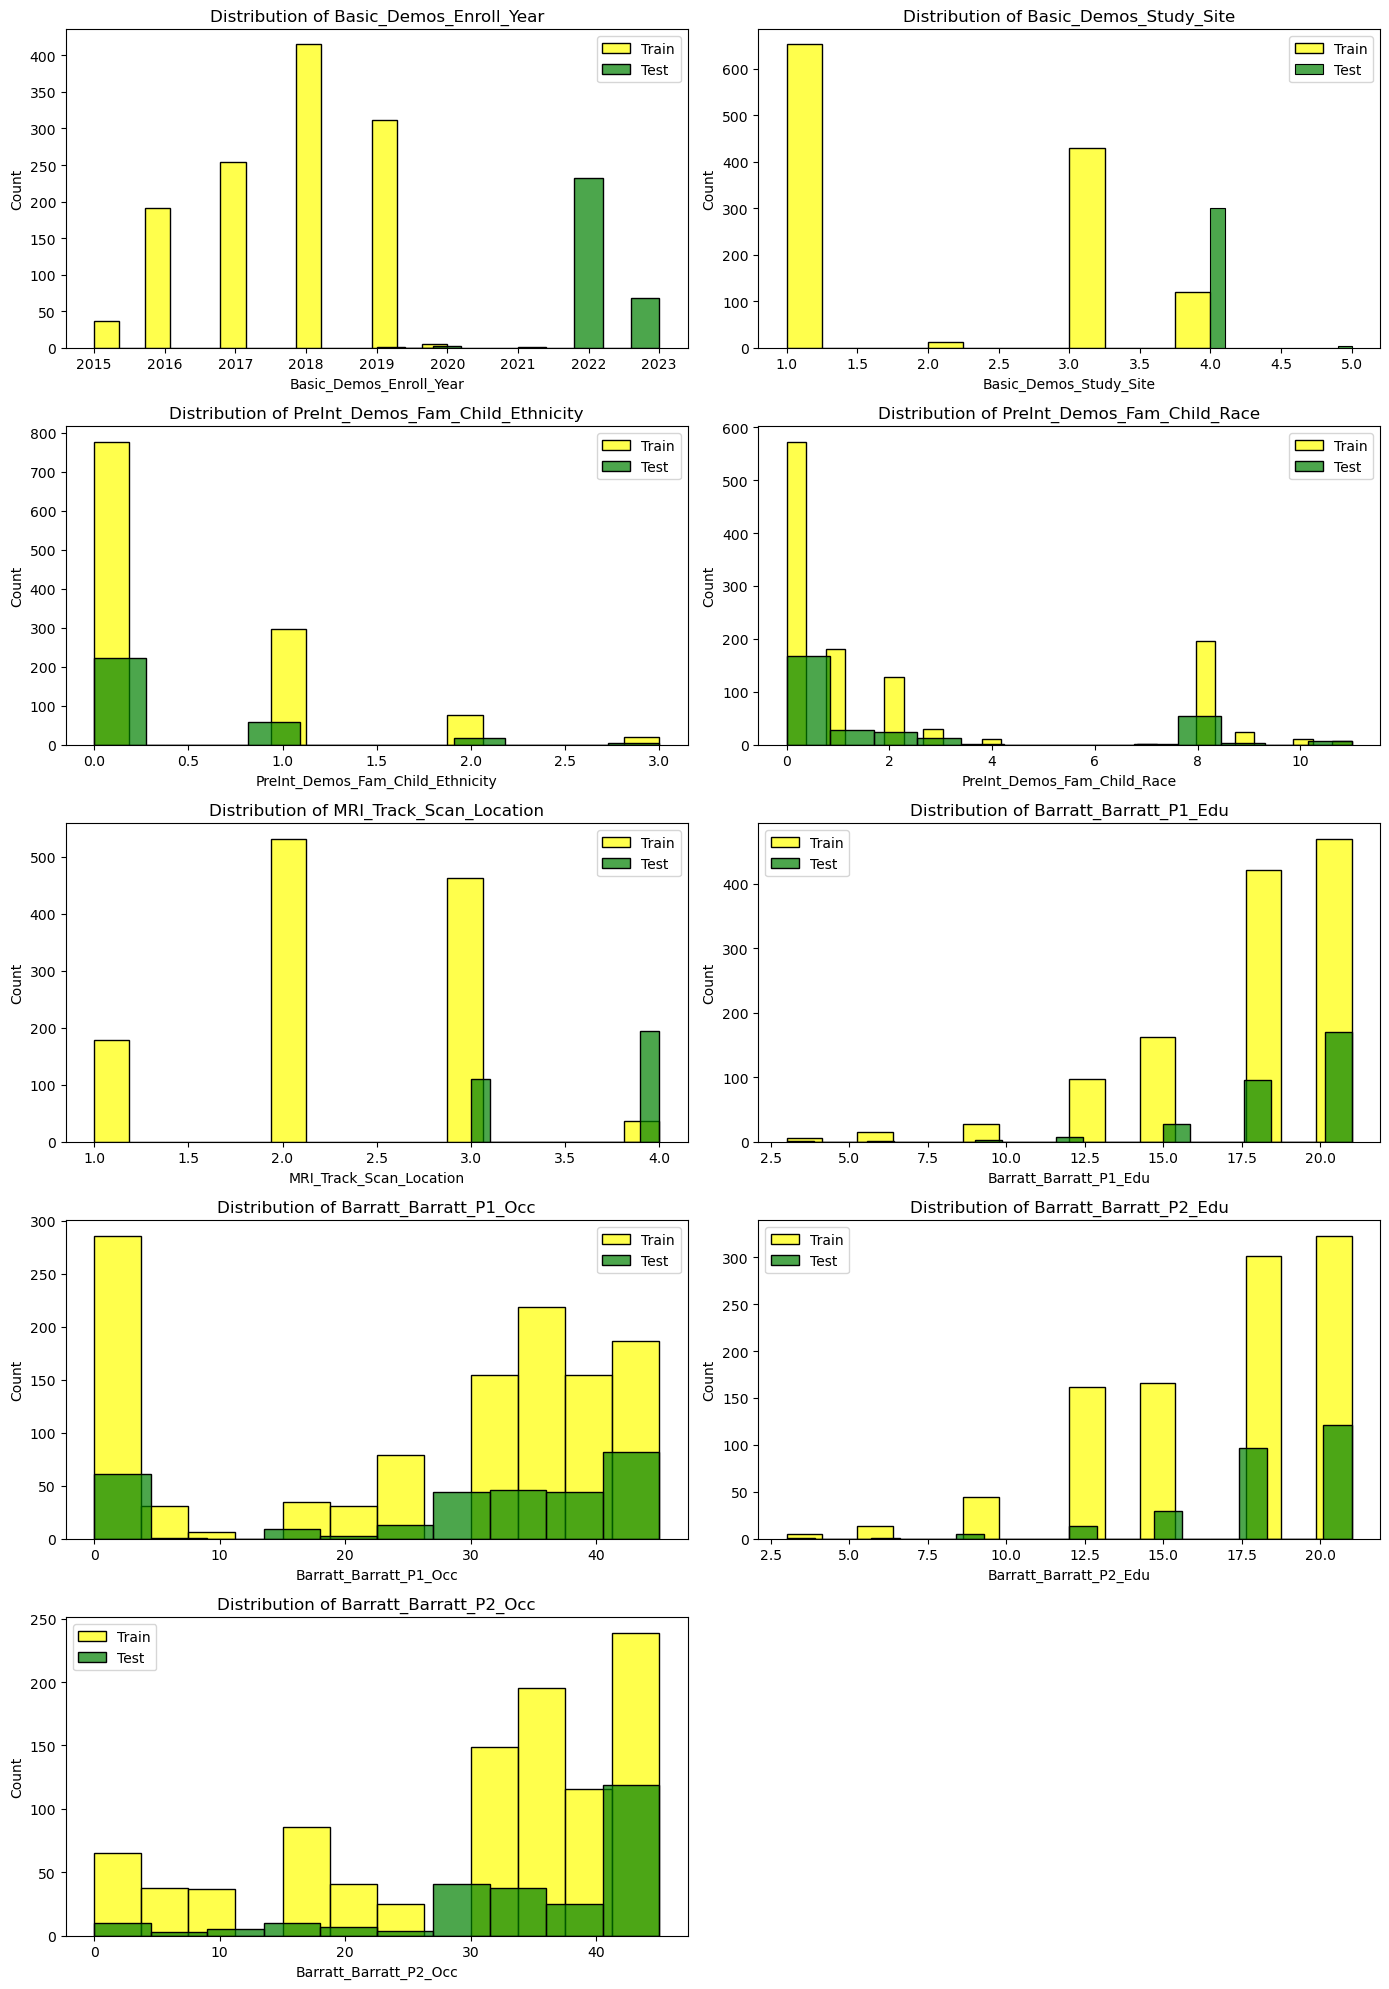

In [26]:
# Get list of columns common to both dataframes, excluding participant_id
cols = [col for col in train_cat.columns if col != 'participant_id']

# Set up the figure dimensions; adjust n_rows and n_cols as needed
n_cols = 2
n_rows = (len(cols) + 1) // n_cols

plt.figure(figsize=(14, 4 * n_rows))

for idx, col in enumerate(cols, 1):
    plt.subplot(n_rows, n_cols, idx)
    # Plot the training set distribution
    sns.histplot(train_cat[col], color="yellow", label="Train", alpha=0.7, multiple = "dodge")
    # Plot the test set distributions
    sns.histplot(test_cat[col], color="green", label="Test", alpha=0.7, multiple = "dodge")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.legend()

plt.tight_layout()
plt.show()

Most variables have similar distributions across the training and test datasets there is no (or very little) overlap in enrolment year (*Basic_Demos_Enroll_Year*), study site (*Basic_Demos_Study_Site*) and MRI location (*MRI_Track_Scan_Location*).

#### Conclusion

We drop the following categorical variables as there is no (or very little) overlap in values between the training and test datasets:
- Basic_Demos_Enroll_Year
- Basic_Demos_Study_Site
- MRI_Track_Scan_Location

Also, we see that there are some differences in frequencies based on the child's race, ethnicity and the parents education and occupations which means that it is worth keeping the other categorical variables as they seem to have prediction power.

Not covered here but worth exploring if the education and occupation of both parents could be merged into one variable via dimension reduction to avoid multicollinearity.

In [27]:
cat_columns_to_drop = ['Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site', 'MRI_Track_Scan_Location']

### Quantitative variables

Inspect the first few rows of the training dataset for quantitative (or numberic) input variables.

In [28]:
train_quant.head()

,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,00aIpNTbG5uh,100.00,13.0,3.0,15.0,44.0,14.0,20.0,27.0,3.0,17.0,4.0,11.0,5.0,8.0,6.0,2.0,9.0,14.274127
1,00fV0OyyoLfw,92.27,14.0,3.0,12.0,35.0,25.0,28.0,30.0,5.0,20.0,4.0,13.0,5.0,8.0,7.0,3.0,8.0,NaN
2,04X1eiS79T4B,86.67,14.0,3.0,21.0,37.0,18.0,26.0,28.0,3.0,24.0,7.0,10.0,10.0,7.0,14.0,7.0,7.0,13.463381
3,05ocQutkURd6,93.34,14.0,3.0,11.0,42.0,15.0,20.0,28.0,0.0,5.0,0.0,3.0,0.0,3.0,2.0,2.0,6.0,9.572553
4,06YUNBA9ZRLq,0.00,14.0,8.0,12.0,35.0,22.0,12.0,24.0,6.0,23.0,7.0,15.0,8.0,9.0,8.0,1.0,4.0,6.654574


View number of rows and columns (=shape) of the original dataframe:

In [29]:
train_quant.shape


(1213, 19)

Check the columns of quantitative variabes:

In [30]:
train_quant.columns

Index(['participant_id', 'EHQ_EHQ_Total', 'ColorVision_CV_Score',
       'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV',
       'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP',
       'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total',
       'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing',
       'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Hyperactivity',
       'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial',
       'MRI_Track_Age_at_Scan'],
      dtype='object')

Use .info() and .describe() to provide basic informatino and descriptive statistics about the quantitive variables:

In [31]:
train_quant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   participant_id              1213 non-null   object 
 1   EHQ_EHQ_Total               1200 non-null   float64
 2   ColorVision_CV_Score        1190 non-null   float64
 3   APQ_P_APQ_P_CP              1201 non-null   float64
 4   APQ_P_APQ_P_ID              1201 non-null   float64
 5   APQ_P_APQ_P_INV             1201 non-null   float64
 6   APQ_P_APQ_P_OPD             1201 non-null   float64
 7   APQ_P_APQ_P_PM              1201 non-null   float64
 8   APQ_P_APQ_P_PP              1201 non-null   float64
 9   SDQ_SDQ_Conduct_Problems    1204 non-null   float64
 10  SDQ_SDQ_Difficulties_Total  1204 non-null   float64
 11  SDQ_SDQ_Emotional_Problems  1204 non-null   float64
 12  SDQ_SDQ_Externalizing       1204 non-null   float64
 13  SDQ_SDQ_Generating_Impact   1204 

We can see that the dataset is quite complete, missing data mainly affects MRI Age at scan only (853 entries out of 1213 available, 360 missing). For other features, the number of missing values is relatively small (not more than 23 = 1213 = 1190 instances).

In [32]:
train_quant.describe()

,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
count,1200.000000,1190.000000,1201.000000,1201.000000,1201.000000,1201.000000,1201.000000,1201.000000,1204.000000,1204.000000,1204.000000,1204.000000,1204.000000,1204.000000,1204.000000,1204.000000,1204.000000,853.000000
mean,59.514750,13.419328,3.819317,13.337219,39.767694,17.963364,16.557036,25.498751,2.074751,12.213455,2.324751,7.613787,4.103821,5.539037,4.599668,2.274917,7.740864,11.245678
std,49.744631,2.112830,1.330348,3.593562,4.872729,3.333965,5.146548,3.053720,2.022992,6.517330,2.166399,4.130399,2.808079,2.807063,3.510469,2.089041,2.094832,3.234372
min,-100.000000,0.000000,2.000000,5.000000,23.000000,7.000000,5.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,46.670000,14.000000,3.000000,11.000000,36.000000,16.000000,13.000000,23.000000,0.000000,7.000000,1.000000,5.000000,2.000000,4.000000,2.000000,0.000000,6.000000,8.803901
50%,77.800000,14.000000,3.000000,13.000000,40.000000,18.000000,16.000000,26.000000,2.000000,12.000000,2.000000,8.000000,4.000000,6.000000,4.000000,2.000000,8.000000,10.739219
75%,94.470000,14.000000,4.000000,16.000000,43.000000,20.000000,19.000000,28.000000,3.000000,17.000000,4.000000,10.000000,6.000000,8.000000,7.000000,4.000000,10.000000,13.460871
max,100.000000,14.000000,12.000000,28.000000,50.000000,28.000000,37.000000,30.000000,10.000000,34.000000,10.000000,20.000000,10.000000,10.000000,17.000000,9.000000,10.000000,21.564453


Plot the distribution of MRI track age at scan variable:

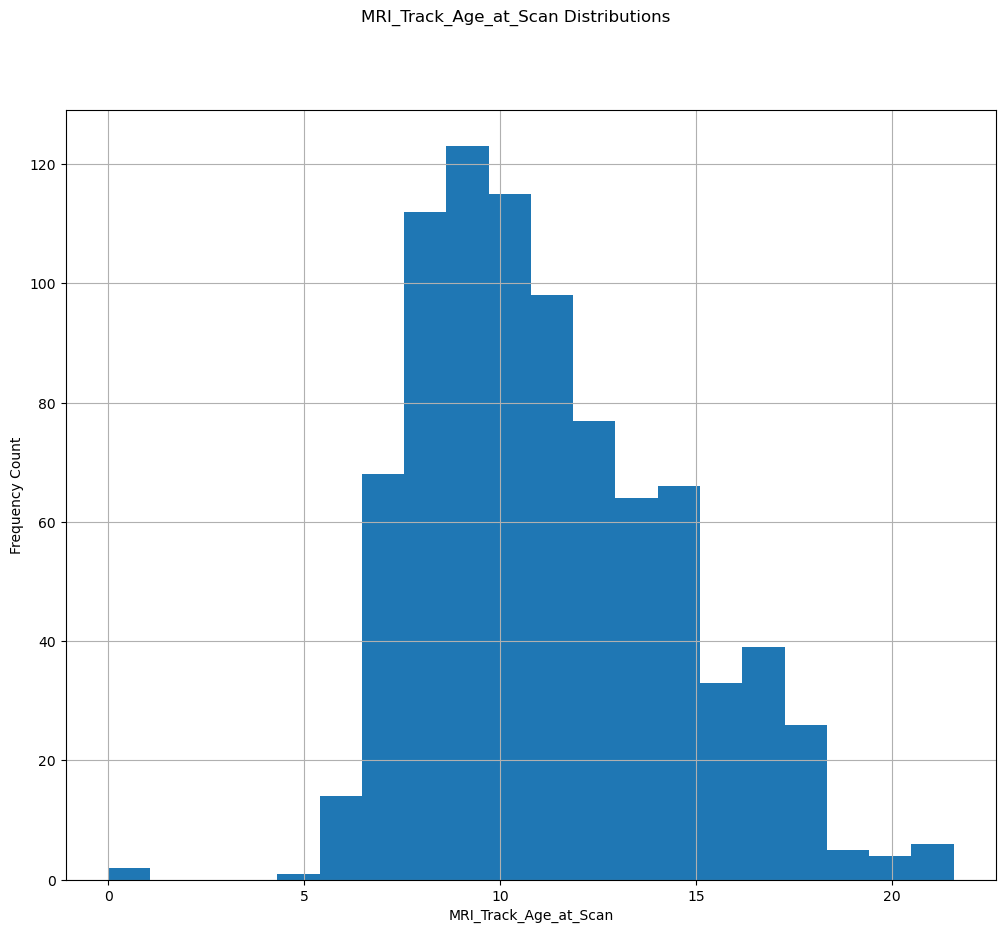

In [33]:
train_quant['MRI_Track_Age_at_Scan'].hist(figsize=(12, 10), bins=20)
plt.suptitle("MRI_Track_Age_at_Scan Distributions")
plt.xlabel('MRI_Track_Age_at_Scan')
plt.ylabel('Frequency Count')
plt.show()

Plot the distribution of the SDQ_SDQ_Emotional_Problems variable:

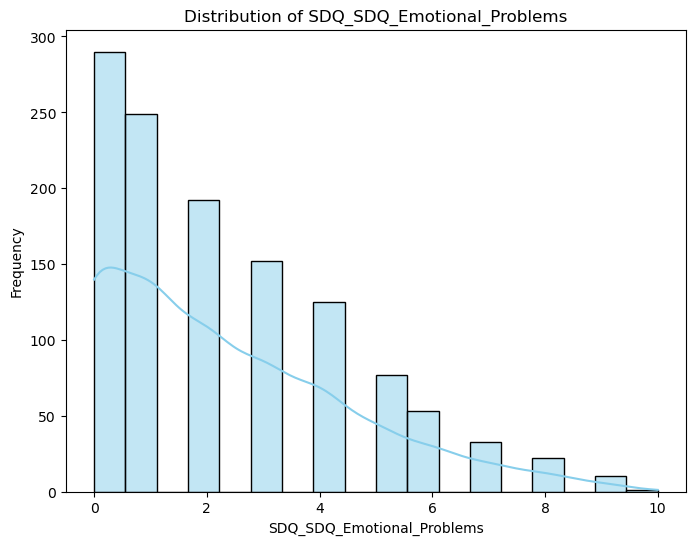

In [34]:
plt.figure(figsize=(8, 6))
sns.histplot(train_quant['SDQ_SDQ_Emotional_Problems'], kde=True, color='skyblue')
plt.title('Distribution of SDQ_SDQ_Emotional_Problems')
plt.xlabel('SDQ_SDQ_Emotional_Problems')
plt.ylabel('Frequency')
plt.show()

Check for correlation with ADHD outcome:

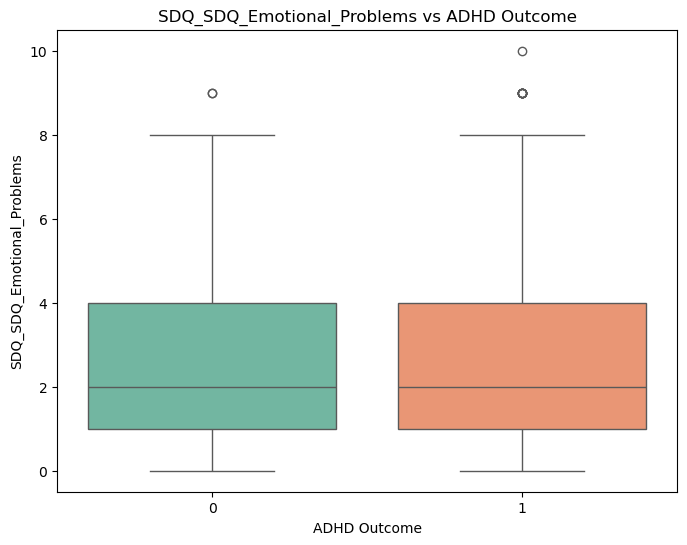

In [35]:
# Check for correlation with ADHD outcome
train_quant_copy = train_quant.copy()
train_quant_copy['ADHD_Outcome'] = train_solutions['ADHD_Outcome']

plt.figure(figsize=(8, 6))
sns.boxplot(x='ADHD_Outcome', y='SDQ_SDQ_Emotional_Problems', data=train_quant_copy, palette="Set2")
plt.title('SDQ_SDQ_Emotional_Problems vs ADHD Outcome')
plt.xlabel('ADHD Outcome')
plt.ylabel('SDQ_SDQ_Emotional_Problems')
plt.show()

We can see that patients with ADHD have more emotional problems, therefore it is worth keeping this input variable as it has prediction power.

Generate box plots for all quantitative variables:

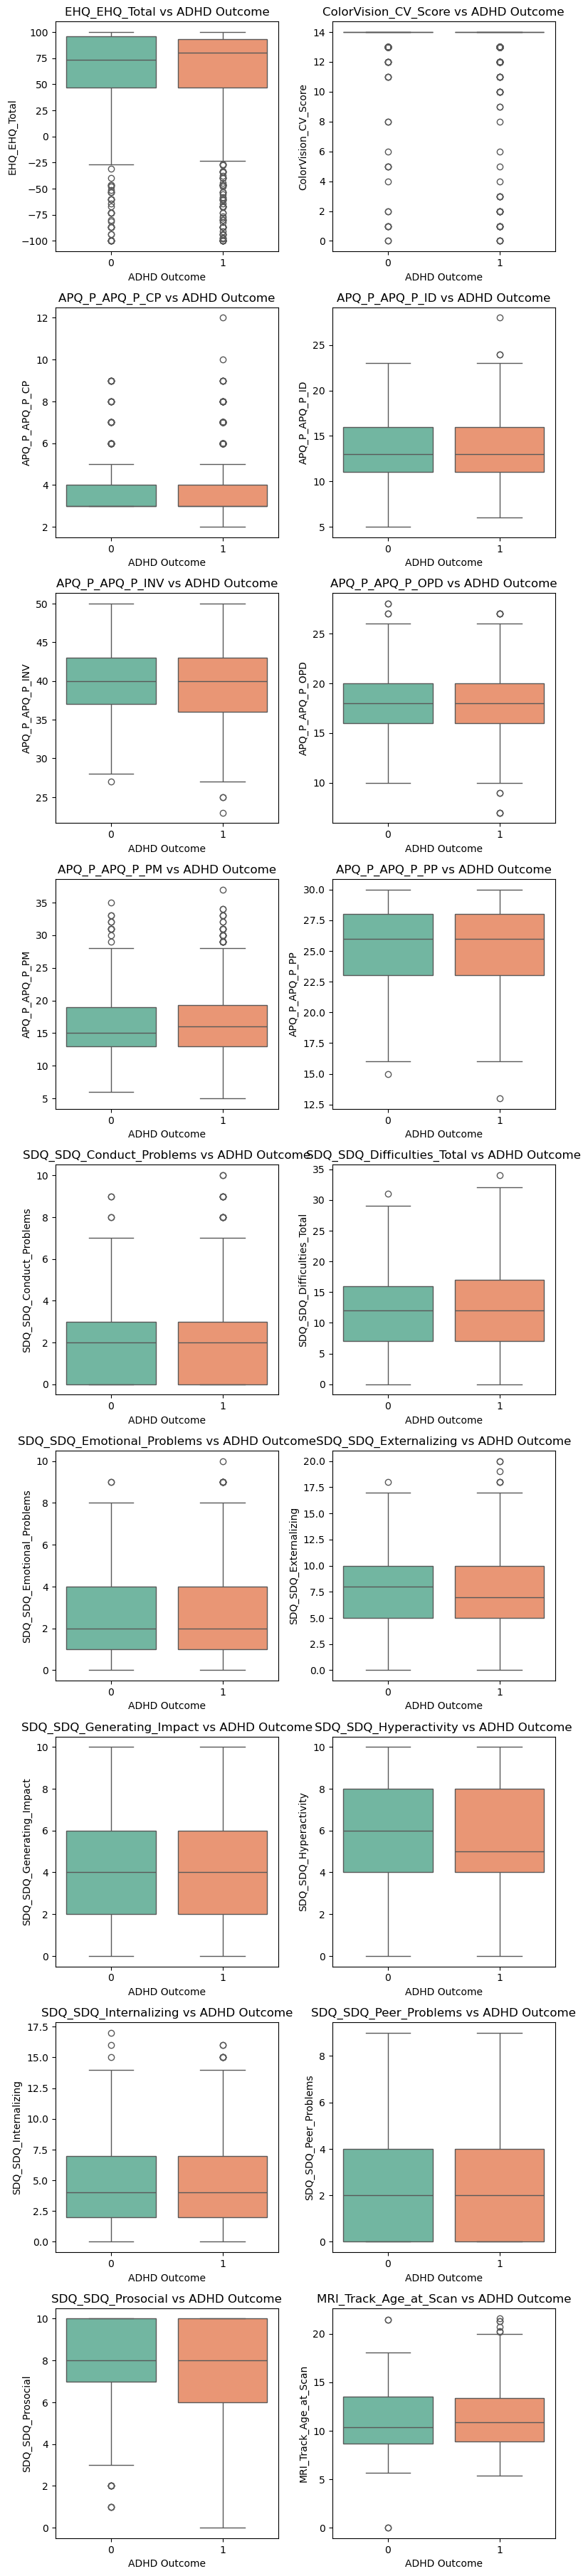

In [36]:
# List of numeric columns to plot, excluding the id and target columns
cols_to_plot = [col for col in train_quant_copy.select_dtypes(include=['number']).columns 
                if col != 'ADHD_Outcome']

# Determine the grid size; here we'll plot one row per column
n_cols = 2
n_rows = len(cols_to_plot)

plt.figure(figsize=(8, 4 * n_rows))  # Adjust height per number of plots

for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x='ADHD_Outcome', y=col, data=train_quant_copy, palette="Set2")
    plt.title(f'{col} vs ADHD Outcome')
    plt.xlabel('ADHD Outcome')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

#### Correlations

Compute correlations of quantitative columns:

In [37]:
corr_matrix_train_quant = train_quant.iloc[:,1:].corr()
print(corr_matrix_train_quant)

                            EHQ_EHQ_Total  ColorVision_CV_Score  \
EHQ_EHQ_Total                    1.000000              0.011680   
ColorVision_CV_Score             0.011680              1.000000   
APQ_P_APQ_P_CP                  -0.040262              0.025139   
APQ_P_APQ_P_ID                  -0.009224             -0.022344   
APQ_P_APQ_P_INV                 -0.013310             -0.029387   
APQ_P_APQ_P_OPD                 -0.052585             -0.012615   
APQ_P_APQ_P_PM                   0.030519             -0.030832   
APQ_P_APQ_P_PP                  -0.031832              0.000217   
SDQ_SDQ_Conduct_Problems        -0.048658              0.003944   
SDQ_SDQ_Difficulties_Total      -0.047746              0.002189   
SDQ_SDQ_Emotional_Problems      -0.028570              0.024828   
SDQ_SDQ_Externalizing           -0.023944              0.002035   
SDQ_SDQ_Generating_Impact       -0.006730              0.037464   
SDQ_SDQ_Hyperactivity           -0.000150              0.00014

Create heatmap of correlation factors:

<Axes: >

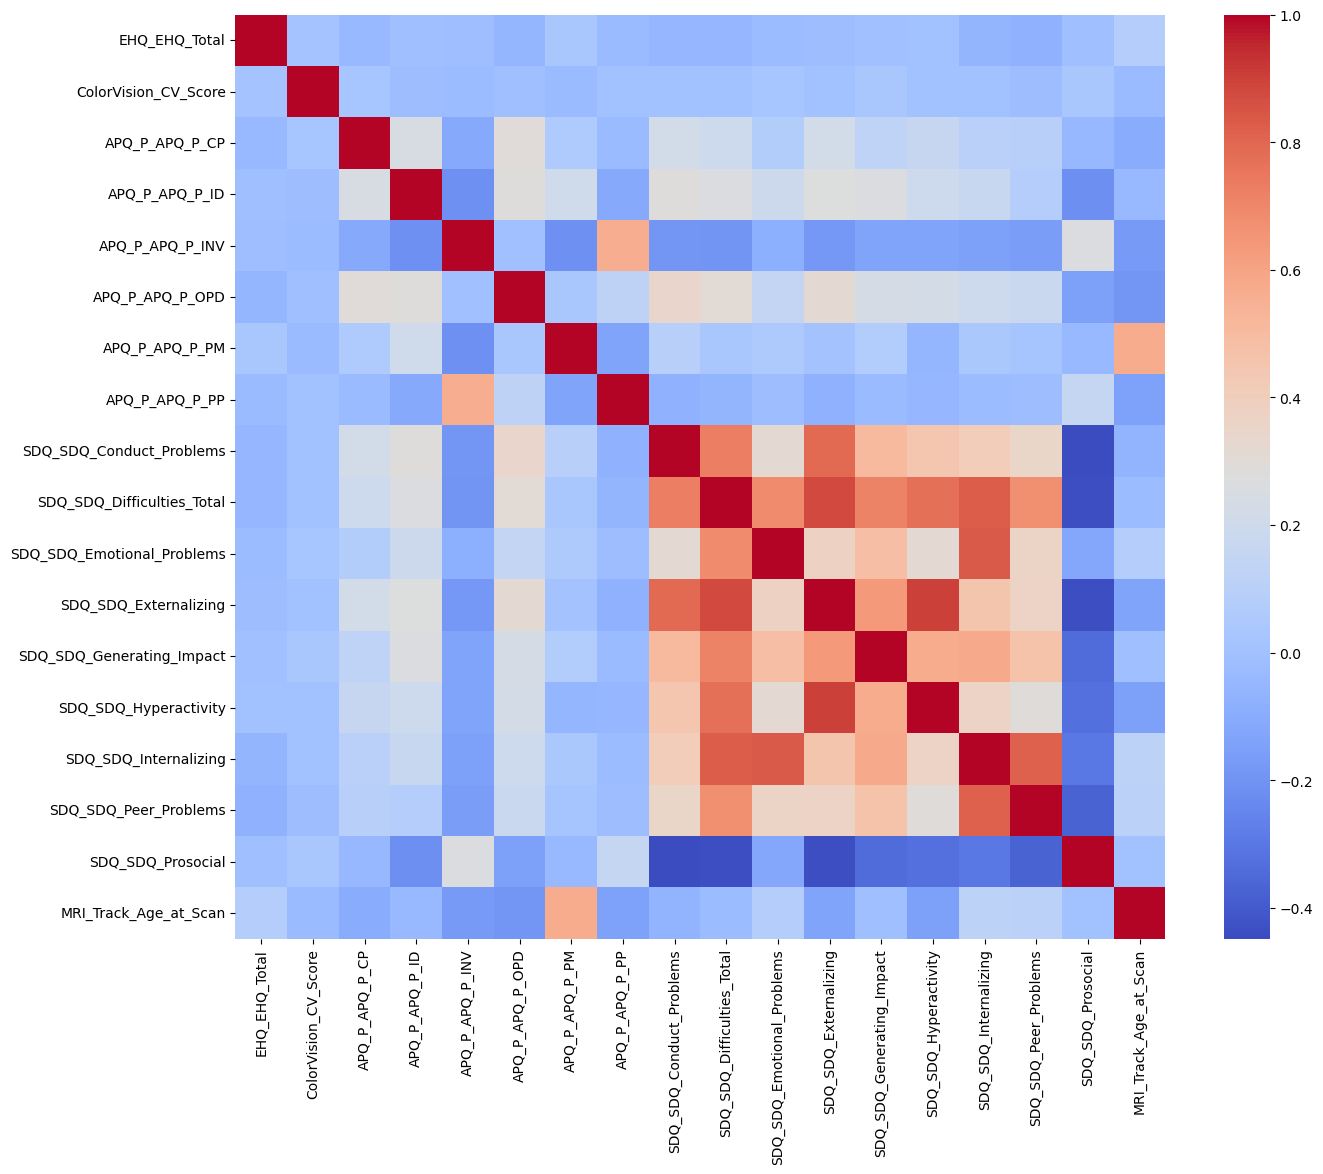

In [38]:
plt.figure(figsize=(15, 12)) 
sns.heatmap(corr_matrix_train_quant, cmap = 'coolwarm')

We can see that the SDQ variabiles (related to emotional problems, difficulties) are correlated, see orange square. It may be worth merging these into one variable to avoid multicollinearity:

#### Compare distributions in test vs training datasets

Verify that the columns are the same between the training and test dataset:

In [39]:
train_quant.columns

Index(['participant_id', 'EHQ_EHQ_Total', 'ColorVision_CV_Score',
       'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV',
       'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP',
       'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total',
       'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing',
       'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Hyperactivity',
       'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial',
       'MRI_Track_Age_at_Scan'],
      dtype='object')

In [40]:
test_quant.columns

Index(['participant_id', 'EHQ_EHQ_Total', 'ColorVision_CV_Score',
       'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV',
       'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP',
       'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total',
       'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing',
       'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Hyperactivity',
       'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial',
       'MRI_Track_Age_at_Scan'],
      dtype='object')

Compare the distributions of quantitative variables (excl. particpant id). Note that similar comparison (and more) can be achived with the Sweetviz library, not covered here.

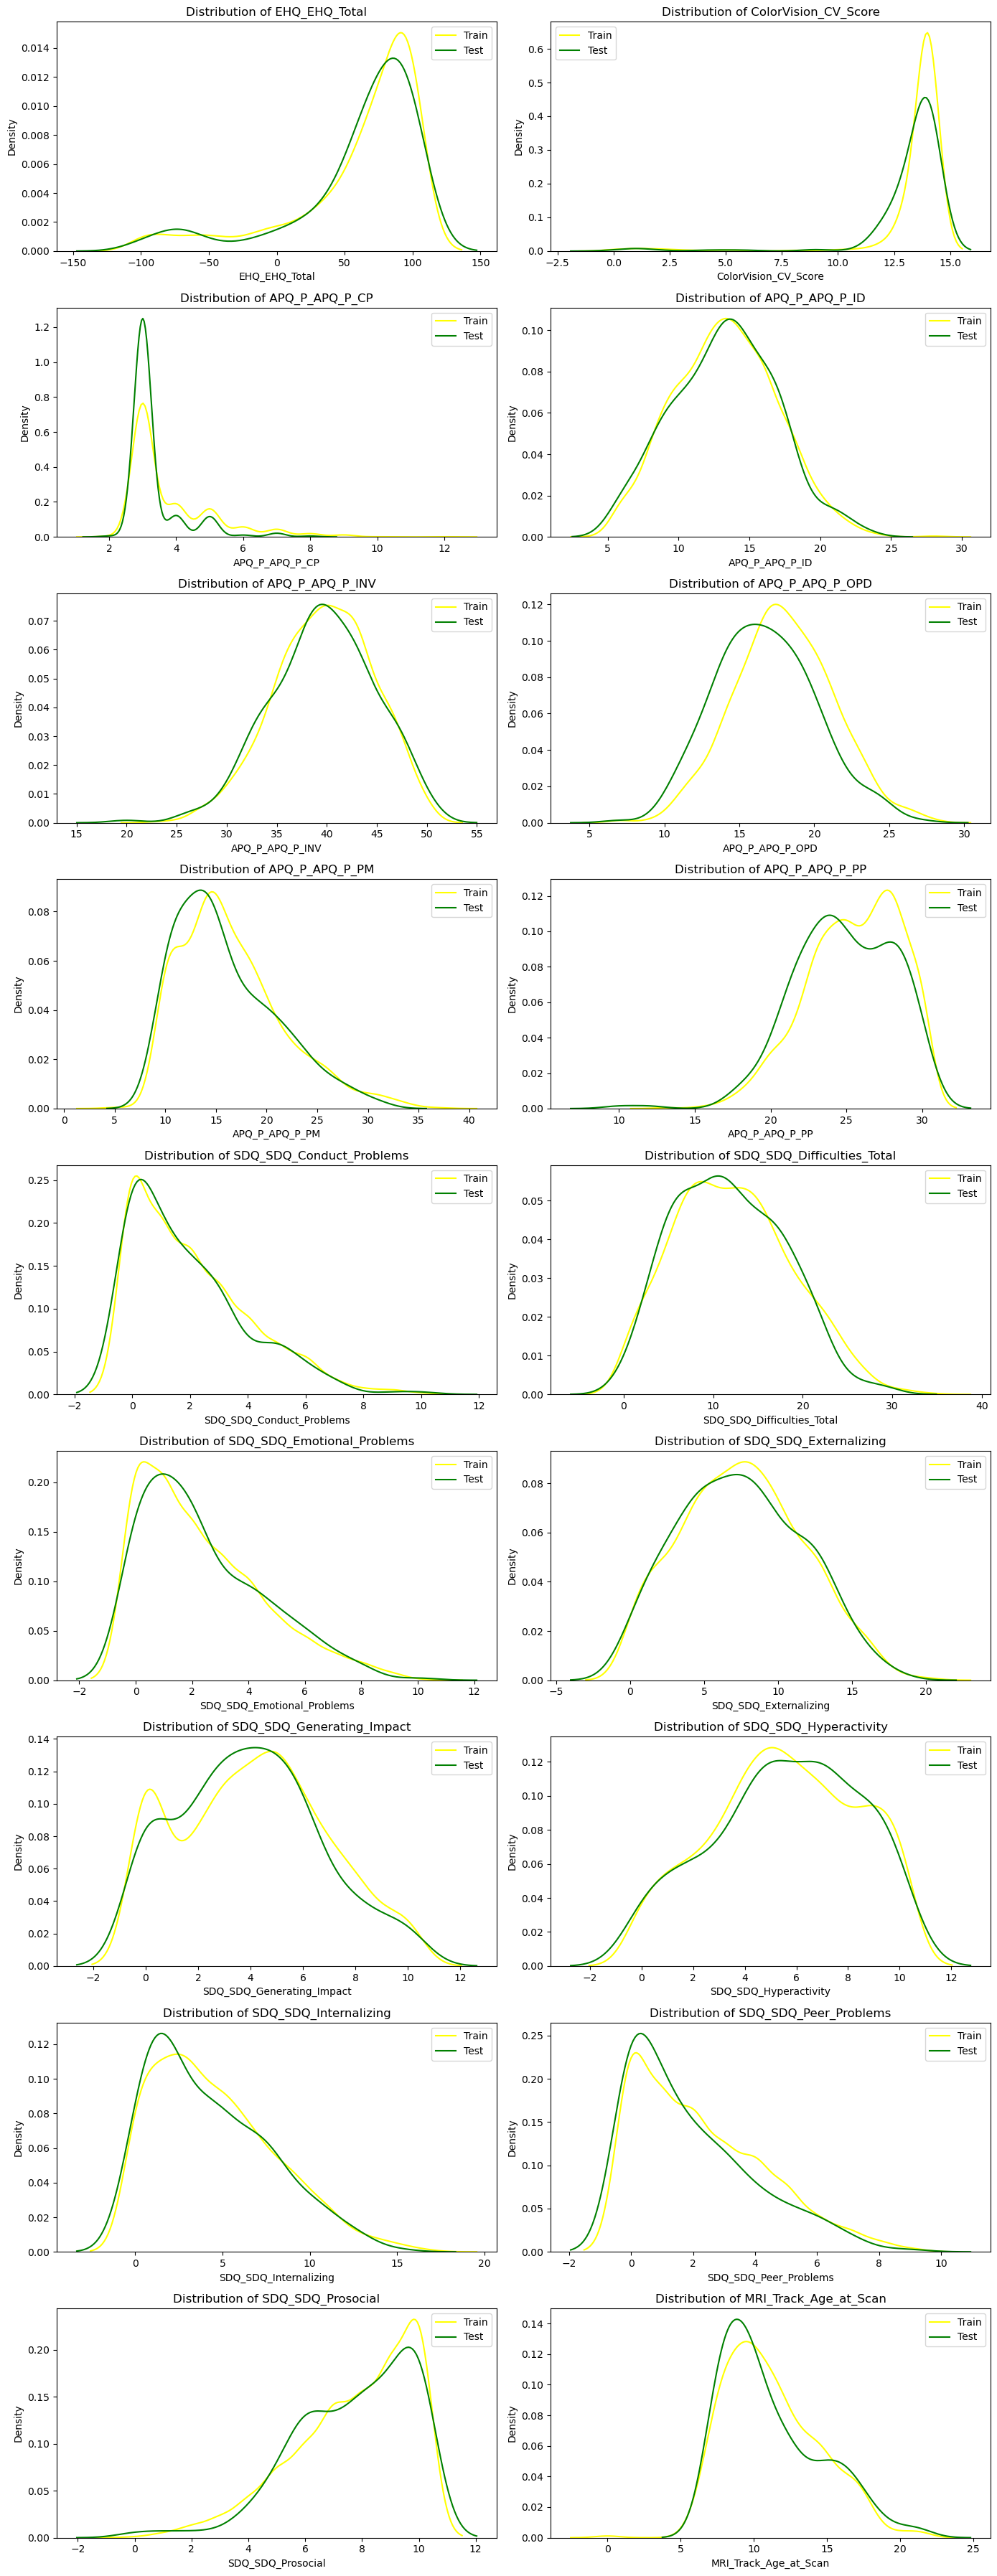

In [41]:
# Get list of columns common to both dataframes, excluding participant_id
cols = [col for col in train_quant.columns if col != 'participant_id']

# Set up the figure dimensions; adjust n_rows and n_cols as needed
n_cols = 2
n_rows = (len(cols) + 1) // n_cols

plt.figure(figsize=(14, 4 * n_rows))

for idx, col in enumerate(cols, 1):
    plt.subplot(n_rows, n_cols, idx)
    # Plot the training set distribution
    sns.kdeplot(train_quant[col], color="yellow",label="Train")
    # Plot the test set distribution
    sns.kdeplot(test_quant[col], color="green", label="Test")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.legend()

plt.tight_layout()
plt.show()

The distribution of all variables appear similar across between the training and test dataset, therefore no reason to drop any of them due to this.

#### Conclusion

Based on the analysis I will drop the following quantitative variables as these do not appear to differ significantly between participants with or without ADHD diagnosis:
 - EHQ_EHQ_Total (handedness - left or right)
 - APQ_P_APQ_P_CP (corporal punishment)
 - MRI_Track_Age_at_Scan

No other changes to the original quantitative variables but it would be worth doing further experiments:
 - To validate our assumption tha the inclusion of any of the variables above will not increase the accuracy of the prediction signifianctly
 - As SDQ variables are correlated, merging them into one (or a few) variables via dimension reduction may reduce multicollinearity and therefore increase the accuracy of the prediction

In [42]:
quant_columns_to_drop = ['EHQ_EHQ_Total', 'APQ_P_APQ_P_CP', 'MRI_Track_Age_at_Scan']

Create full list of columns to be dropped from data (both training and test) by merging the lists for categorical and quantitative variables:

In [43]:
columns_to_drop = cat_columns_to_drop + quant_columns_to_drop

In [44]:
print(columns_to_drop)

['Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site', 'MRI_Track_Scan_Location', 'EHQ_EHQ_Total', 'APQ_P_APQ_P_CP', 'MRI_Track_Age_at_Scan']


### Connectome matrices (MRI scan data on intensity of connection between brain cells)

Analysis of connectome matrices based on a shared notebook [WiDS 2025 EDA step by step workshop ATX NYC](https://www.kaggle.com/code/anugarania/wids-2025-eda-step-by-step-workshop-atx-nyc).  The code was modified to include all columns of the connectome matrix data.

Note that these matrices measure the intensity of connection between 200 brain cells. This is symmetric (intensity between cell *i* and *j* same as between *j* and *i*), also intensity not measured between the same cell. So alltogether the number of connections for each participant in the original dataset is: <br><br>
   19 900 = 200 * 199 / 2 as this is too large, dimension reduction is applied (see Data Preprocessing section).

Double check if the number of columns in the connectome matrix is indeed 19900:

In [45]:
connectome_cols = [col for col in train.columns if 'throw' in col]
print(len(connectome_cols))

19900


Verify that there are no missing values:

In [46]:
train_connectome = train[connectome_cols].copy()


# Check for missing values in the training data
missing = train_connectome.isnull().sum()
missing_percent = 100 * missing / len(train_connectome)
missing_df = pd.DataFrame({
    'Missing Values': missing,
    'Percentage': missing_percent
})


# Display features with missing values
missing_features = missing_df[missing_df['Missing Values'] > 0].sort_values('Percentage', ascending=False)

missing_features_rows, missing_featurues_cols = missing_features.shape

if missing_features_rows == 0:
    print('No missing records')

else:
    print("\nFeatures with missing values in training data:")
    missing_features


No missing records


Analyse brain connectivity.

=== BRAIN CONNECTIVITY ANALYSIS ===
Number of brain connectivity features: 19900
First few connectivity features: ['0throw_1thcolumn', '0throw_2thcolumn', '0throw_3thcolumn', '0throw_4thcolumn', '0throw_5thcolumn']


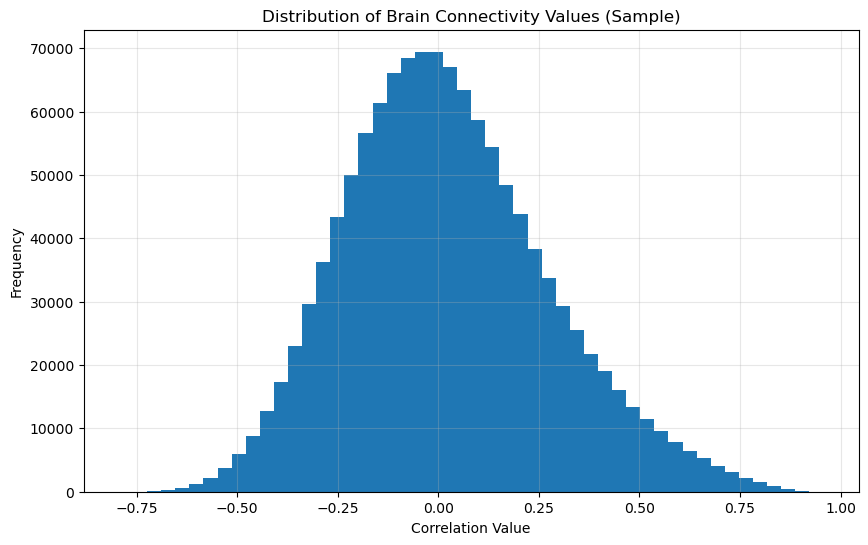

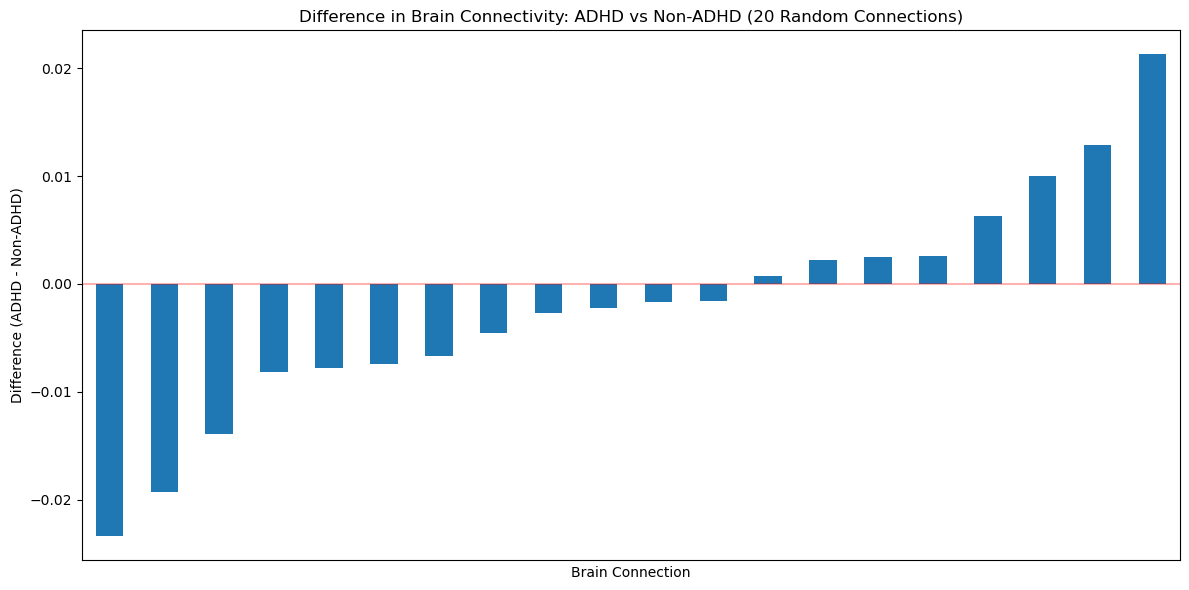

In [47]:
print("=== BRAIN CONNECTIVITY ANALYSIS ===")

# 1. Identify brain connectivity features
print(f"Number of brain connectivity features: {len(connectome_cols)}")
print(f"First few connectivity features: {connectome_cols[:5]}")

# 2. Distribution of connectivity values (sample)
plt.figure(figsize=(10, 6))
# Take a random sample to avoid memory issues
sample_size = min(1000, len(connectome_cols))
np.random.seed(42)
sample_cols = np.random.choice(connectome_cols, sample_size)
all_values = train[sample_cols].values.flatten()
all_values = all_values[~np.isnan(all_values)]  # Remove NaN values if any

plt.hist(all_values, bins=50)
plt.title('Distribution of Brain Connectivity Values (Sample)')
plt.xlabel('Correlation Value')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

# 3. Simple visualization of connectivity difference between ADHD and non-ADHD
# Take just 20 random features for a simple comparison
sample_size = 20
np.random.seed(42)
tiny_sample = np.random.choice(connectome_cols, sample_size)

# Calculate means by group
adhd_means = train[train['ADHD_Outcome']==1][tiny_sample].mean()
non_adhd_means = train[train['ADHD_Outcome']==0][tiny_sample].mean()
diff = adhd_means - non_adhd_means


# Plot differences
plt.figure(figsize=(12, 6))
diff.sort_values().plot(kind='bar')
plt.title('Difference in Brain Connectivity: ADHD vs Non-ADHD (20 Random Connections)')
plt.xlabel('Brain Connection')
plt.ylabel('Difference (ADHD - Non-ADHD)')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.xticks([])  # Hide feature names to avoid clutter
plt.tight_layout()
plt.show()


Understanding brain connectivity data

=== UNDERSTANDING BRAIN CONNECTIVITY DATA ===
Number of brain connectivity features: 19900
First few connectivity features: ['0throw_1thcolumn', '0throw_2thcolumn', '0throw_3thcolumn', '0throw_4thcolumn', '0throw_5thcolumn']

What do these features mean?
- Each feature (like '0throw_1stcolumn') represents the correlation between two brain regions
- Values range from -1 to +1
- Positive values: regions activate together
- Negative values: when one region activates, the other tends to deactivate
- Values close to zero: little relationship between regions

=== SAMPLE BRAIN CONNECTIVITY VALUES ===
For the first subject in our dataset:
0throw_1thcolumn: 0.3613
0throw_2thcolumn: 0.7914
0throw_3thcolumn: 0.5307
0throw_4thcolumn: 0.6231
0throw_5thcolumn: 0.8458


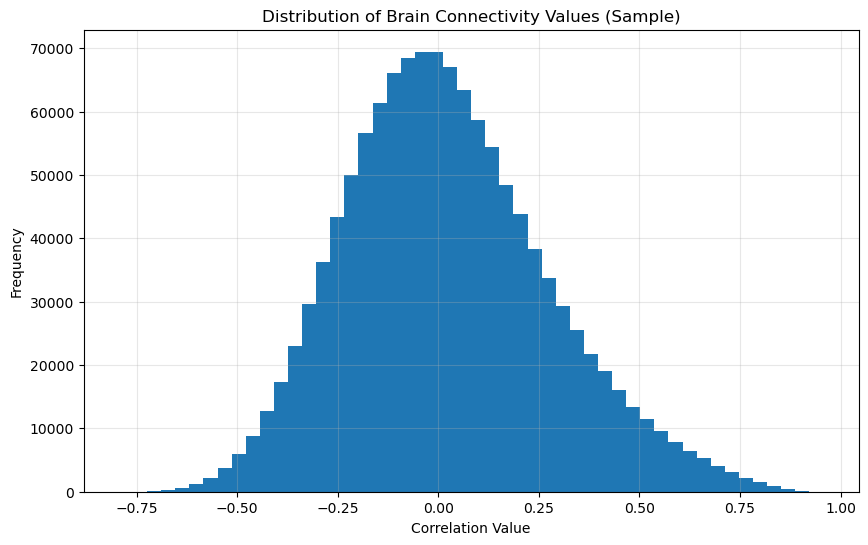


The histogram shows us how brain connectivity values are distributed.
Most values are centered around zero, with fewer strong positive or negative correlations.

=== COMPARING BRAIN CONNECTIVITY: ADHD VS NON-ADHD ===
                        ADHD  Non-ADHD  Difference
108throw_190thcolumn -0.1617   -0.1642      0.0025
4throw_75thcolumn    -0.2186   -0.2119     -0.0067
29throw_55thcolumn   -0.0488   -0.0472     -0.0016
73throw_139thcolumn  -0.0930   -0.0696     -0.0234
68throw_99thcolumn    0.1498    0.1285      0.0213
34throw_95thcolumn   -0.0822   -0.0741     -0.0082
121throw_153thcolumn -0.1067   -0.1092      0.0025
23throw_126thcolumn   0.4394    0.4416     -0.0022
94throw_183thcolumn   0.0662    0.0736     -0.0074
68throw_178thcolumn   0.2299    0.2171      0.0129


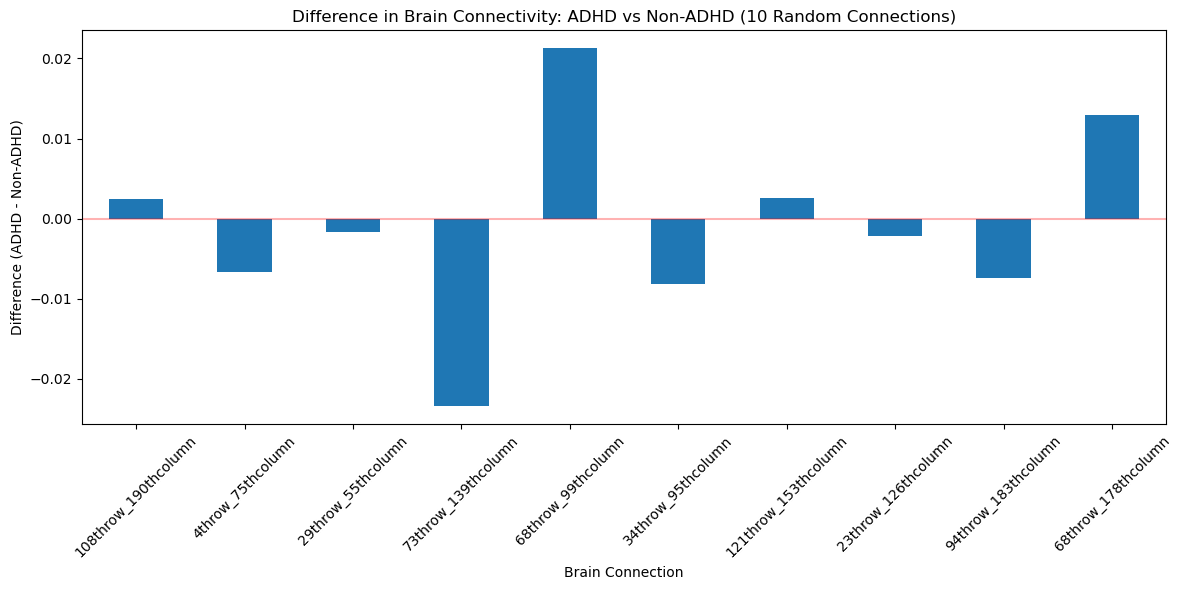


This bar chart shows differences in brain connectivity between ADHD and non-ADHD groups.
Bars above zero: connections stronger in ADHD subjects
Bars below zero: connections stronger in non-ADHD subjects
Even with just 10 random connections, we can see differences between the groups!


In [48]:
print("=== UNDERSTANDING BRAIN CONNECTIVITY DATA ===")

# 1. First, let's understand what our connectivity data looks like

print(f"Number of brain connectivity features: {len(connectome_cols)}")
print(f"First few connectivity features: {connectome_cols[:5]}")

print("\nWhat do these features mean?")
print("- Each feature (like '0throw_1stcolumn') represents the correlation between two brain regions")
print("- Values range from -1 to +1")
print("- Positive values: regions activate together")
print("- Negative values: when one region activates, the other tends to deactivate")
print("- Values close to zero: little relationship between regions")


# 3. Let's look at some sample connectivity values first
print("\n=== SAMPLE BRAIN CONNECTIVITY VALUES ===")
# Show a few sample values from the first subject
sample_subject = train.iloc[0]
print("For the first subject in our dataset:")
for i, col in enumerate(connectome_cols[:5]):
    print(f"{col}: {sample_subject[col]:.4f}")

# 4. Distribution of connectivity values
plt.figure(figsize=(10, 6))
# Take a random sample to avoid memory issues
sample_size = min(1000, len(connectome_cols))
np.random.seed(42)
sample_cols = np.random.choice(connectome_cols, sample_size)
all_values = train[sample_cols].values.flatten()
all_values = all_values[~np.isnan(all_values)]  # Remove NaN values if any

plt.hist(all_values, bins=50)
plt.title('Distribution of Brain Connectivity Values (Sample)')
plt.xlabel('Correlation Value')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

print("\nThe histogram shows us how brain connectivity values are distributed.")
print("Most values are centered around zero, with fewer strong positive or negative correlations.")

# 5. Simple comparison between ADHD and non-ADHD
print("\n=== COMPARING BRAIN CONNECTIVITY: ADHD VS NON-ADHD ===")
# Take just 10 random features for a simple comparison
sample_size = 10
np.random.seed(42)
tiny_sample = np.random.choice(connectome_cols, sample_size)

# Calculate means by group
adhd_means = train[train['ADHD_Outcome']==1][tiny_sample].mean()
non_adhd_means = train[train['ADHD_Outcome']==0][tiny_sample].mean()
diff = adhd_means - non_adhd_means

# Create a comparative table
comparison = pd.DataFrame({
    'ADHD': adhd_means,
    'Non-ADHD': non_adhd_means,
    'Difference': diff
})
print(comparison.round(4))

# Plot differences
plt.figure(figsize=(12, 6))
diff.plot(kind='bar')
plt.title('Difference in Brain Connectivity: ADHD vs Non-ADHD (10 Random Connections)')
plt.xlabel('Brain Connection')
plt.ylabel('Difference (ADHD - Non-ADHD)')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nThis bar chart shows differences in brain connectivity between ADHD and non-ADHD groups.")
print("Bars above zero: connections stronger in ADHD subjects")
print("Bars below zero: connections stronger in non-ADHD subjects")
print("Even with just 10 random connections, we can see differences between the groups!")

#### Dimension reduction with Principal Component Analysis (PCA)

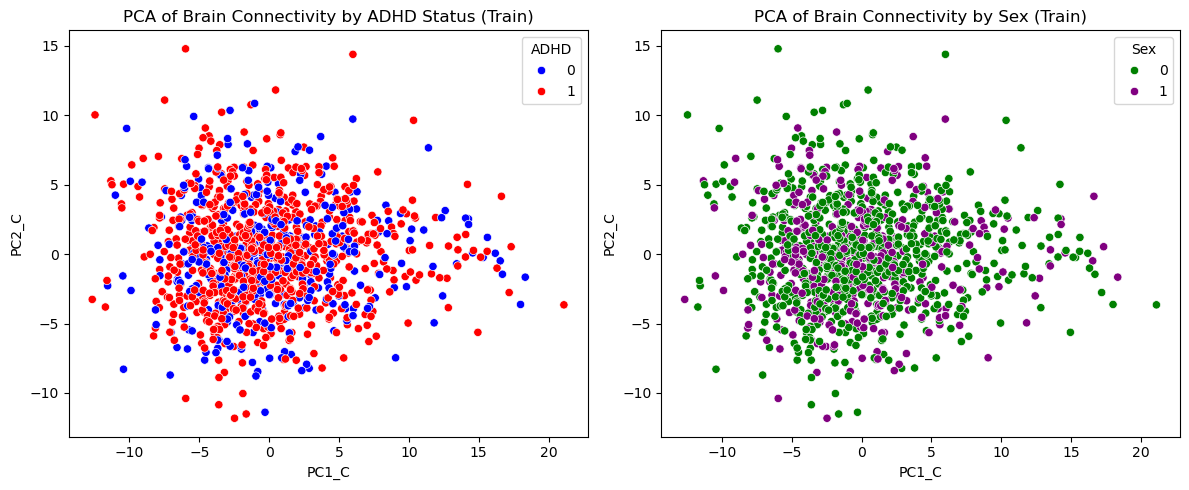

Variance explained by PC1: 4.97%
Variance explained by PC2: 2.69%


In [49]:
# 4. Simple PCA on a subset of connectivity features
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Take 500 random features for PCA
sample_size = min(500, len(connectome_cols)) 
np.random.seed(42)
pca_sample = np.random.choice(connectome_cols, sample_size)

# Standardize the data
X = train[pca_sample].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with PCA results
pca_train_df_connectome = pd.DataFrame({
    'PC1_C': X_pca[:, 0],
    'PC2_C': X_pca[:, 1],
    'ADHD': train['ADHD_Outcome'].values,
    'Sex': train['Sex_F'].values
})

# Set PCA columns:
pca_cols_connectome = ['PC1_C', 'PC2_C']

# Plot PCA results
plt.figure(figsize=(12, 5))

# By ADHD
plt.subplot(1, 2, 1)
sns.scatterplot(x='PC1_C', y='PC2_C', hue='ADHD', data=pca_train_df_connectome, palette=['blue', 'red'])
plt.title('PCA of Brain Connectivity by ADHD Status (Train)')

# By Sex
plt.subplot(1, 2, 2)
sns.scatterplot(x='PC1_C', y='PC2_C', hue='Sex', data=pca_train_df_connectome, palette=['green', 'purple'])
plt.title('PCA of Brain Connectivity by Sex (Train)')

plt.tight_layout()
plt.show()

# Print explained variance
print(f"Variance explained by PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"Variance explained by PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")


Repeat the same for the test dataset:

In [50]:
# Take 500 random features for PCA
sample_size = min(500, len(connectome_cols)) 
np.random.seed(42)
pca_sample = np.random.choice(connectome_cols, sample_size)

# Standardize the data
X = test[pca_sample].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with PCA results
pca_test_df_connectome = pd.DataFrame({
    'PC1_C': X_pca[:, 0],
    'PC2_C': X_pca[:, 1]
})

# Print explained variance
print(f"Variance explained by PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"Variance explained by PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")


Variance explained by PC1: 9.52%
Variance explained by PC2: 2.86%


#### Conclusion

Other dimension reduction methods should be explored as the first two PCA components explain 1.61% (=0.79% + 0.62%) of the variance only, this should be much higher (at least >60% but ideally >80%) for the method to work well. Still a good starting point and data visualisation.

Still, for now we are using the two PCA components instead of the original large number (19900) connectome columns.

## 4. Data Preprocessing <a name="data-preprocessing"></a>

We preprocess the data via the following steps:
1. Drop variables with limited prediction power (see EDA section for rationale)
2. Dimension Reduction
3. Handle missing values
4. Encode categorical features
5. Scale numerical features

### 4.1 Drop variables with limited prediction power

Drop categorical and quantitative variables that have no prediction power.

#### Categorical variables

Check number of categorical variables before removing columns.

In [51]:
print(train_cat.shape[1])
print(test_cat.shape[1])

10
10


Check all columns before drop:

In [52]:
train_cat.columns

Index(['participant_id', 'Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site',
       'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
       'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu',
       'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
       'Barratt_Barratt_P2_Occ'],
      dtype='object')

Check columns to be dropped:

In [53]:
cat_columns_to_drop

['Basic_Demos_Enroll_Year',
 'Basic_Demos_Study_Site',
 'MRI_Track_Scan_Location']

Drop columns:

In [54]:
train_cat = train_cat.drop(cat_columns_to_drop, axis = 1)
test_cat  = test_cat.drop(cat_columns_to_drop, axis = 1)

Check number of columns after drop:

In [55]:
print(train_cat.shape[1])
print(test_cat.shape[1])

7
7


#### Quantitative variables

Check number of categorical variables before removing columns.

In [56]:
print(train_quant.shape[1])
print(test_quant.shape[1])

19
19


Check all columns before drop:

In [57]:
train_quant.columns

Index(['participant_id', 'EHQ_EHQ_Total', 'ColorVision_CV_Score',
       'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV',
       'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP',
       'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total',
       'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing',
       'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Hyperactivity',
       'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial',
       'MRI_Track_Age_at_Scan'],
      dtype='object')

In [58]:
test_quant.columns

Index(['participant_id', 'EHQ_EHQ_Total', 'ColorVision_CV_Score',
       'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV',
       'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP',
       'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total',
       'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing',
       'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Hyperactivity',
       'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial',
       'MRI_Track_Age_at_Scan'],
      dtype='object')

Check columns to be dropped:

In [59]:
quant_columns_to_drop

['EHQ_EHQ_Total', 'APQ_P_APQ_P_CP', 'MRI_Track_Age_at_Scan']

Drop columns:

In [60]:
train_quant = train_quant.drop(quant_columns_to_drop, axis = 1)
test_quant  = test_quant.drop(quant_columns_to_drop, axis = 1)

Check number of columns after drop:

In [61]:
print(train_quant.shape[1])
print(test_quant.shape[1])

16
16


### 4.2 Dimension reduction

#### 4.2.1 Quantitative variables (excl. connectome matrices) - PCA

Import sklearn libraries for PCA:

In [62]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Set number of PCA components for quantitative variables so that the components explain a high percentage (at least 60%) of the variance 

In [63]:
nr_pca_components = 4

Run PCA on quantitative variables of the training dataset:

In [64]:
# Extract the ID column
participant_id = train_quant.iloc[:, 0]

# Select only numeric columns for PCA:
train_quant_numeric = train_quant.iloc[:, 1:]

# Replace missing values by the mean as otherwise PCA does not run:
train_quant_numeric.fillna(train_quant_numeric.median(), inplace=True)

# Standardise data:
scaler = StandardScaler()
train_quant_scaled = scaler.fit_transform(train_quant_numeric)

# Apply PCA:
pca = PCA(n_components= nr_pca_components)
train_quant_pca = pca.fit_transform(train_quant_scaled)

# Set PCA columns:
pca_columns = []
for i in range(0,nr_pca_components):
    pca_columns.append(f"PC{i+1}")

# Convert dataframe:
train_quant_pca = pd.DataFrame(train_quant_pca, columns= pca_columns)

# Add Back the participant_id:
train_quant_pca.insert(0, 'participant_id', participant_id.values)

# Check variance explained:
explained_variance = pca.explained_variance_ratio_
total_explained_variance = explained_variance.sum()

print(f"Variance explained by each component of training dataset: {explained_variance}")
print(f"Total variance explained by {nr_pca_components} components of training dataset: {total_explained_variance:.1%}")

Variance explained by each component of training dataset: [0.37171401 0.1153836  0.09330114 0.0771751 ]
Total variance explained by 4 components of training dataset: 65.8%


Run PCA on quantitative variables of the test dataset and check if proportion of variance explained is similar:

In [65]:
# Extract the ID column:
participant_id = test_quant.iloc[:, 0]

# Select only numeric columns for PCA:
test_quant_numeric = test_quant.iloc[:, 1:]

# Replace missing values by the mean as otherwise PCA does not run:
test_quant_numeric.fillna(test_quant_numeric.median(), inplace=True)

# Standardise data:
scaler = StandardScaler()
test_quant_scaled = scaler.fit_transform(test_quant_numeric)

# Apply PCA:
pca = PCA(n_components= nr_pca_components)
test_quant_pca = pca.fit_transform(test_quant_scaled)

# Set PCA columns:
pca_columns = []
for i in range(0,nr_pca_components):
    pca_columns.append(f"PC{i+1}")

# Convert dataframe:
test_quant_pca = pd.DataFrame(test_quant_pca, columns= pca_columns)

# Add Back the participant_id:
test_quant_pca.insert(0, 'participant_id', participant_id.values)

# Check variance explained:
explained_variance = pca.explained_variance_ratio_
total_explained_variance = explained_variance.sum()

print(f"Variance explained by each component of test dataset: {explained_variance}")
print(f"Total variance explained by {nr_pca_components} components of test datset: {total_explained_variance:.1%}")

Variance explained by each component of test dataset: [0.34525835 0.14545011 0.11801099 0.07264277]
Total variance explained by 4 components of test datset: 68.1%


It is reassuring that in the test dataset the 6 components also explain 60% of the variance just like in the training dataset.

Decision if PCA to be used on quanititative variables excl. connectome matrices (recommended as removes multicollienarity):

In [66]:
apply_pca_quant = True

Update training and test dataset by replacing original columns with the PCA columns:

In [67]:
if apply_pca_quant == True:
    train.drop(columns=train_quant.columns[1:], inplace=True)
    train[pca_columns] = train_quant_pca[pca_columns]
    test.drop(columns  = test_quant.columns[1:], inplace=True)
    test[pca_columns]  = test_quant_pca[pca_columns]
else:
    pass

#### 4.2.2 Connectome matrices - PCA

Decision if PCA to be used for connectome matrices (recommended as removes multicollienarity):

In [68]:
apply_pca_connectome = True

In [69]:
if apply_pca_connectome == True:
    train.drop(columns = connectome_cols, inplace=True)
    train[pca_cols_connectome] = pca_train_df_connectome[pca_cols_connectome]
    test.drop(columns  = connectome_cols, inplace=True)
    test[pca_cols_connectome]  = pca_test_df_connectome[pca_cols_connectome]
else:
    pass

Inspect the shape of the training and test datasets after conversion to PCA:

In [70]:
train.shape

(1213, 21)

In [71]:
train.head()

,participant_id,EHQ_EHQ_Total,APQ_P_APQ_P_CP,MRI_Track_Age_at_Scan,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,...,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,ADHD_Outcome,Sex_F,PC1,PC2,PC3,PC4,PC1_C,PC2_C
0,00aIpNTbG5uh,100.00,3.0,14.274127,2019,4,1.0,0.0,3.0,21.0,...,NaN,NaN,1,0,1.085904,0.755622,0.004759,0.133211,-3.500698,-1.874321
1,00fV0OyyoLfw,92.27,3.0,NaN,2017,1,0.0,9.0,2.0,21.0,...,21.0,45.0,1,0,2.736402,0.177058,-0.862840,1.757402,-3.118809,-2.822043
2,04X1eiS79T4B,86.67,3.0,13.463381,2017,1,1.0,2.0,2.0,9.0,...,NaN,NaN,0,1,4.615385,0.268469,2.058301,2.397296,-3.660931,-4.088129
3,05ocQutkURd6,93.34,3.0,9.572553,2018,1,3.0,8.0,2.0,18.0,...,18.0,0.0,0,1,-2.672445,-0.013702,0.244977,0.026056,-0.664263,-4.866939
4,06YUNBA9ZRLq,0.00,8.0,6.654574,2018,1,0.0,1.0,2.0,12.0,...,NaN,NaN,1,0,4.215837,-0.122339,-0.696390,-1.023063,4.055709,-3.507702


In [72]:
test.shape

(304, 19)

In [73]:
test.head()

,participant_id,EHQ_EHQ_Total,APQ_P_APQ_P_CP,MRI_Track_Age_at_Scan,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,PC1,PC2,PC3,PC4,PC1_C,PC2_C
0,Cfwaf5FX7jWK,60.03,5.0,8.992813,2022,4,0.0,0.0,4,21.0,30.0,18.0,30.0,0.007726,1.426155,-0.321336,0.953979,-0.358886,-0.132694
1,vhGrzmvA3Hjq,86.71,3.0,12.324093,2023,4,0.0,0.0,4,21.0,45.0,NaN,30.0,1.606539,-0.626603,3.261655,0.394079,-3.163829,-3.061702
2,ULliyEXjy4OV,26.68,3.0,7.770933,2022,4,0.0,0.0,4,21.0,40.0,18.0,40.0,-1.937999,0.363441,-0.954367,0.271279,-1.904669,1.986327
3,LZfeAb1xMtql,93.38,3.0,9.304814,2022,4,0.0,0.0,3,21.0,45.0,21.0,45.0,2.128393,0.639787,-0.396121,0.365319,-1.266910,-0.675604
4,EnFOUv0YK1RG,-93.38,3.0,8.261350,2022,4,2.0,0.0,4,18.0,0.0,21.0,45.0,1.760740,1.312748,0.930941,0.991615,2.230024,0.761283


### 4.3 Handle missing values

Import sklearn libraries for data preprocessing:

In [74]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

Double check number of missing records in the training dataset:

In [75]:
# Check for missing values in the training data
missing = train.isnull().sum()
missing_percent = 100 * missing / len(train)
missing_df = pd.DataFrame({
    'Missing Values': missing,
    'Percentage': missing_percent
})


# Display features with missing values
missing_features = missing_df[missing_df['Missing Values'] > 0].sort_values('Percentage', ascending=False)
print("\nFeatures with missing values in training data:")
missing_features



Features with missing values in training data:


,Missing Values,Percentage
MRI_Track_Age_at_Scan,360,29.678483
Barratt_Barratt_P2_Occ,222,18.301731
Barratt_Barratt_P2_Edu,198,16.323166
PreInt_Demos_Fam_Child_Race,54,4.451772
PreInt_Demos_Fam_Child_Ethnicity,43,3.544930
Barratt_Barratt_P1_Occ,31,2.555647
Barratt_Barratt_P1_Edu,15,1.236603
EHQ_EHQ_Total,13,1.071723
APQ_P_APQ_P_CP,12,0.989283
MRI_Track_Scan_Location,3,0.247321


As shown in the table above and also in the EDA section, the dataset is quite complete, there are only a few missing data entries:
- *Categorical variables:*             11 records missing from Ethnicity (out of 1,213), all records available for other input variables
- *Quantitative variables (incl. connectome matrices):*            360 records missing from MRI Track Age at Scan (out of 1,213) - and this variable is removed anyway - all records available for other input variables.

Due to this, simple stragies are used using **SimpleImputer** for imputing data for missing records:
 - *Categorical variables:*            *most frequent* (or mode)
  - *Quantitative variables:* (incl. connectome matrices):          *median* 

Other strategies offered by SimpleImputer include using the *mean* or a *constant*, not used here.

More sophisticated imputing methods are also available in sklearn, the most popular one is using a *regression* on other input variables with **IterativeImputer**, also not used here. This method works well if the input variable (or feature) is related to other features. Different approaches can be used for the *estimator* argument (BayesianRidge, DecisionTreeRegressor, KNN), not covered in details here but all set up in sklearn.

<u>**Encoding categorical variables**</u>

For some machine learning methods (like LGBM) encoding of categorical variables is required. A so called *one hot encoding* method is used which means that so called dummy or binary (0 or 1) variables are created for each value of each categorical input variable.

This is not required for some methods e.g. CatBoost as they have built in functionality to handle this.

#### Other Data Preprocessing:

<u>**Scaling**</u>

Due to the different scale of quantitative (or numeric) input variables, scaling is needed for certain machine learning methods. 

Note that scaling is not strictly required for tree-based models such as LGBM - although it can help with speeding up optimisation - but is important for:
- Distance based methods (e.g. KNN, SVM)
- Regularised models (e.g. Ridge or Lasso)
- Gradient based methods (e.g. neural networks)

The *StandardScaler* is used here which simple deducts the mean and divides the difference by the standard deviation.


In [76]:
# Add participant_id and target variables to the list of columns to drop:
columns_to_drop.append('participant_id')
columns_to_drop.append('ADHD_Outcome')                     
columns_to_drop.append('Sex_F')

# Separate features and target variables
X = train.drop(columns_to_drop, axis=1, errors='ignore')
y_adhd = train['ADHD_Outcome']
y_sex = train['Sex_F']

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Apply preprocessing to training data
print("Preprocessing data...")
X_preprocessed = preprocessor.fit_transform(X)

print('Shape of preprocessed dataframe: ', X_preprocessed.shape)

Preprocessing data...
Shape of preprocessed dataframe:  (1213, 12)


---

## 5 Model Training <a name="model-training"></a>

We use LightGBM, a gradient boosting framework, to train separate models for ADHD and sex prediction.

### 5.1 Model Training - LGBM

Import libraries:

In [77]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

Run model:

In [78]:
# Split data into training and validation sets
X_train, X_val, y_train_adhd, y_val_adhd, y_train_sex, y_val_sex = train_test_split(
    X_preprocessed, y_adhd, y_sex, test_size=0.2, random_state=42, stratify=y_adhd
)

# Calculate class weights for ADHD and sex
adhd_weights_lgbm = class_weight.compute_class_weight('balanced', classes=np.unique(y_adhd), y=y_adhd)
sex_weights_lgbm = class_weight.compute_class_weight('balanced', classes=np.unique(y_sex), y=y_sex)

# Define LightGBM models
adhd_model_lgbm = lgb.LGBMClassifier(
    objective='binary',
    num_leaves=63,
    learning_rate=0.01,
    n_estimators=1000,
    scale_pos_weight=adhd_weights_lgbm[1] / adhd_weights_lgbm[0],
    early_stopping_rounds=50,
    verbose=-1
)

sex_model_lgmb = lgb.LGBMClassifier(
    objective='binary',
    num_leaves=127,
    learning_rate=0.005,
    n_estimators=1000,
    scale_pos_weight=sex_weights_lgbm[1] / sex_weights_lgbm[0],
    early_stopping_rounds=50,
    verbose=-1
)

# Train ADHD model
print("Training ADHD model...")
adhd_model_lgbm.fit(X_train, y_train_adhd, eval_set=[(X_val, y_val_adhd)])

# Train Sex model
print("Training Sex model...")
sex_model_lgmb.fit(X_train, y_train_sex, eval_set=[(X_val, y_val_sex)])

Training ADHD model...
Training Sex model...


LGBMClassifier(early_stopping_rounds=50, learning_rate=0.005, n_estimators=1000,
               num_leaves=127, objective='binary',
               scale_pos_weight=1.9158653846153846, verbose=-1)

### 5.2 Model Training - CatBoost

In [79]:
import catboost as cb

In [80]:
# Split data into training and validation sets
X_train, X_val, y_train_adhd, y_val_adhd, y_train_sex, y_val_sex = train_test_split(
    X_preprocessed, y_adhd, y_sex, test_size=0.2, random_state=42, stratify=y_adhd
)

# Calculate class weights for ADHD and sex
adhd_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_adhd), y=y_adhd)
sex_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_sex), y=y_sex)

# Define CatBoost models
adhd_model_catboost = cb.CatBoostClassifier(
    loss_function='Logloss',
    depth=8,
    learning_rate=0.01,
    iterations=1000,
    scale_pos_weight=adhd_weights[1] / adhd_weights[0],
    early_stopping_rounds=50,
    verbose=100
)

sex_model_catboost = cb.CatBoostClassifier(
    loss_function='Logloss',
    depth=10,
    learning_rate=0.005,
    iterations=1000,
    scale_pos_weight=sex_weights[1] / sex_weights[0],
    early_stopping_rounds=50,
    verbose=100
)

# Train ADHD model
print("Training ADHD model...")
adhd_model_catboost.fit(X_train, y_train_adhd, eval_set=(X_val, y_val_adhd))

# Train Sex model
print("Training Sex model...")
sex_model_catboost.fit(X_train, y_train_sex, eval_set=(X_val, y_val_sex))

Training ADHD model...
0:	learn: 0.6884358	test: 0.6909487	best: 0.6909487 (0)	total: 172ms	remaining: 2m 51s
100:	learn: 0.4467004	test: 0.5999007	best: 0.5998783 (99)	total: 1.45s	remaining: 12.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.595816994
bestIteration = 135

Shrink model to first 136 iterations.
Training Sex model...
0:	learn: 0.6915287	test: 0.6932232	best: 0.6932232 (0)	total: 41.4ms	remaining: 41.3s
100:	learn: 0.5660099	test: 0.6902170	best: 0.6901476 (56)	total: 4.12s	remaining: 36.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6895332203
bestIteration = 118

Shrink model to first 119 iterations.


---

## 6. Model Evaluation <a name="model-evaluation"></a>

We evaluate the models using the F1 score, which is the competition's evaluation metric.

## 6.1. Model Evaluation - LGBM

In [81]:
from sklearn.metrics import f1_score

# Make predictions on the validation set
adhd_pred_lgbm = adhd_model_lgbm.predict(X_val)
sex_pred_lgbm = sex_model_lgmb.predict(X_val)

# Calculate F1 scores
adhd_f1_lgbm = f1_score(y_val_adhd, adhd_pred_lgbm)
sex_f1_lgbm = f1_score(y_val_sex, sex_pred_lgbm)
combined_f1_lgbm = (adhd_f1_lgbm + sex_f1_lgbm) / 2

print(f"ADHD F1 Score (LGBM): {adhd_f1_lgbm:.4f}")
print(f"Sex F1 Score (LGBM): {sex_f1_lgbm:.4f}")
print(f"Combined F1 Score (LGBM): {combined_f1_lgbm:.4f}")

ADHD F1 Score (LGBM): 0.8071
Sex F1 Score (LGBM): 0.0000
Combined F1 Score (LGBM): 0.4036


## 6.2. Model Evaluation - CatBoost

In [82]:
# Make predictions on the validation set
adhd_pred_catboost = adhd_model_catboost.predict(X_val)
sex_pred_catboost = sex_model_catboost.predict(X_val)

# Calculate F1 scores
adhd_f1_catboost = f1_score(y_val_adhd, adhd_pred_catboost)
sex_f1_catboost = f1_score(y_val_sex, sex_pred_catboost)
combined_f1_catboost = (adhd_f1_catboost + sex_f1_catboost) / 2

print(f"ADHD F1 Score (CatBoost): {adhd_f1_catboost:.4f}")
print(f"Sex F1 Score (CatBoost): {sex_f1_catboost:.4f}")
print(f"Combined F1 Score (CatBoost): {combined_f1_catboost:.4f}")

ADHD F1 Score (CatBoost): 0.7799
Sex F1 Score (CatBoost): 0.3567
Combined F1 Score (CatBoost): 0.5683


---

## 7. Submission Generation <a name="submission-generation"></a>

We generate predictions for the test set and create a submission file.

In [83]:
# Preprocess test data
test_preprocessed = preprocessor.transform(test.drop('participant_id', axis=1, errors='ignore'))

print('Shape of test dataset: ', test_preprocessed.shape)

# Make predictions
if combined_f1_lgbm > combined_f1_catboost:
    test_adhd_pred = adhd_model_lgbm.predict(test_preprocessed)
    test_sex_pred = sex_model_lgmb.predict(test_preprocessed)
else: 
    test_adhd_pred = adhd_model_catboost.predict(test_preprocessed)
    test_sex_pred  = sex_model_catboost.predict(test_preprocessed)

# Create submission file
submission = pd.DataFrame({
    'participant_id': test['participant_id'],
    'ADHD_Outcome': test_adhd_pred,
    'Sex_F': test_sex_pred
})


# Save submission file
# On kaggle just save to the prescribed output folder:
if run_setting == 'kaggle':
    submission.to_csv(f"{output_folder}/submission.csv", index=False)
else:
# If run locally, make a distinction between old and new data:
    submission.to_csv(f"{output_folder}/{old_or_new}/submission.csv", index=False)
    
print("Submission file saved!")

print('Head of submission file: ' , submission.head())

Shape of test dataset:  (304, 12)
Submission file saved!
Head of submission file:    participant_id  ADHD_Outcome  Sex_F
0   Cfwaf5FX7jWK             1      1
1   vhGrzmvA3Hjq             1      1
2   ULliyEXjy4OV             0      0
3   LZfeAb1xMtql             1      0
4   EnFOUv0YK1RG             1      0


---

## 8. Conclusion <a name="conclusion"></a>

In this notebook, we:
1. Loaded and preprocessed the WiDS Datathon 2025 dataset.
2. Trained LightGBM and CatBoost models for ADHD and sex prediction.
3. Evaluated the models using the F1 score.
4. Generated a submission file for the competition.

Further improvements could include:
- Enhance dimension reduction (especially for connectome matrices)
- Experiment with excluding / including other input variables (both categorical and quantitative)
- Hyperparameter tuning
- Compare accuracy with other machine learning methods
- Combine machine learning models instead of using a single one (ensemble models)


Good luck with the competition!

End time measurement:

In [84]:
end_time = time.time()
print('Runtime Jupyter: ', np.round(end_time - start_time, 1), ' seconds')

Runtime Jupyter:  109.5  seconds
